In [3]:
!pip install m3_learning --no-deps
!pip install -r requirements.txt

In [4]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader
import time

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [5]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [6]:
class Linear_func:
    def __init__(self, x, slope=[0,1], b=[0,1], size=(1,1),batch_size=1000, verbose=False):
        self.x = x

        self.slope = slope
        self.slope_mean = torch.tensor(slope[0] + slope[1]) / 2
        self.slope_sd = torch.sqrt(torch.pow(torch.tensor(slope[1]) - torch.tensor(slope[0]), 2) / 12)
        
        self.b = b
        self.b_mean = torch.tensor(b[0] + b[1]) / 2
        self.b_sd = torch.sqrt(torch.pow(torch.tensor(b[1]) - torch.tensor(b[0]), 2) / 12)
        
        self.size = size
        self.batch_size = batch_size
        self.verbose = verbose

    def compute(self, params, device='cuda'):
        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _slope = params[:, 0, 0, i]
                _b = params[:, 0, 1, i]

            if params.ndim == 3:
                _slope = params[:, 0, i]
                _b = params[:, 1, i]

            x = (
                torch.cat(params.shape[0] * [self.x])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x = torch.transpose(x, 0, 1)  # .to(device)

            _out = _slope * x + _b

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)
    
    def sampler(self, device='cuda'):
        slope = rand_tensor(
            min=self.slope[0],
            max=self.slope[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        b = rand_tensor(
            min=self.b[0],
            max=self.b[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        _params = torch.torch.stack((slope, b))
        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)
        
        return (self.compute(_params, device=device), _params)

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted

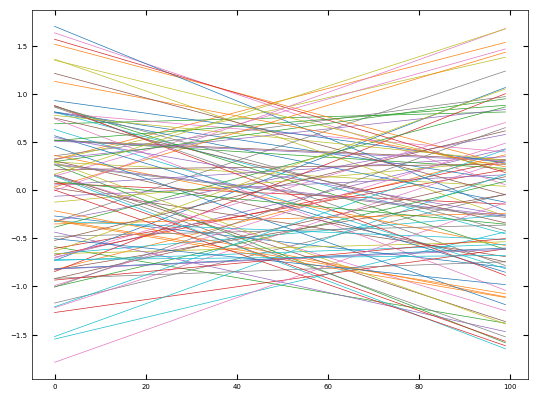

In [33]:
constructor = Linear_func(x=torch.linspace(-1, 1, 100), slope=[-1,1], b=[-1,1], batch_size=10000)
output = constructor.sampler()
spectra, params = output
spectra_full, spectras = spectra
dataloader = DataLoader(spectra_full, batch_size=500, shuffle=True, num_workers=0)

for i in range(100):
    plt.plot(spectra_full[i, :, 0].cpu(), "-")

In [34]:
latent_dim = 2
encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [35]:
random_seed(seed=42)
Train(model, encoder, decoder, dataloader, optimizer, 500,)

100%|██████████| 20/20 [00:00<00:00, 68.43it/s]


Epoch 0, Train Loss: 0.4435
.............................


100%|██████████| 20/20 [00:00<00:00, 97.59it/s]


Epoch 1, Train Loss: 0.4426
.............................


100%|██████████| 20/20 [00:00<00:00, 101.86it/s]


Epoch 2, Train Loss: 0.4421
.............................


100%|██████████| 20/20 [00:00<00:00, 86.22it/s]


Epoch 3, Train Loss: 0.4415
.............................


100%|██████████| 20/20 [00:00<00:00, 88.04it/s]


Epoch 4, Train Loss: 0.4407
.............................


100%|██████████| 20/20 [00:00<00:00, 90.09it/s]


Epoch 5, Train Loss: 0.4393
.............................


100%|██████████| 20/20 [00:00<00:00, 87.98it/s]


Epoch 6, Train Loss: 0.4370
.............................


100%|██████████| 20/20 [00:00<00:00, 86.87it/s]


Epoch 7, Train Loss: 0.4329
.............................


100%|██████████| 20/20 [00:00<00:00, 94.52it/s]


Epoch 8, Train Loss: 0.4258
.............................


100%|██████████| 20/20 [00:00<00:00, 80.35it/s]


Epoch 9, Train Loss: 0.4134
.............................


100%|██████████| 20/20 [00:00<00:00, 79.59it/s]


Epoch 10, Train Loss: 0.3924
.............................


100%|██████████| 20/20 [00:00<00:00, 66.52it/s]


Epoch 11, Train Loss: 0.3599
.............................


100%|██████████| 20/20 [00:00<00:00, 77.56it/s]


Epoch 12, Train Loss: 0.3188
.............................


100%|██████████| 20/20 [00:00<00:00, 87.24it/s]


Epoch 13, Train Loss: 0.2826
.............................


100%|██████████| 20/20 [00:00<00:00, 93.74it/s]


Epoch 14, Train Loss: 0.2657
.............................


100%|██████████| 20/20 [00:00<00:00, 87.10it/s]


Epoch 15, Train Loss: 0.2598
.............................


100%|██████████| 20/20 [00:00<00:00, 105.03it/s]


Epoch 16, Train Loss: 0.2539
.............................


100%|██████████| 20/20 [00:00<00:00, 87.42it/s]


Epoch 17, Train Loss: 0.2443
.............................


100%|██████████| 20/20 [00:00<00:00, 77.90it/s]


Epoch 18, Train Loss: 0.2288
.............................


100%|██████████| 20/20 [00:00<00:00, 99.62it/s] 


Epoch 19, Train Loss: 0.2084
.............................


100%|██████████| 20/20 [00:00<00:00, 57.43it/s]


Epoch 20, Train Loss: 0.1924
.............................


100%|██████████| 20/20 [00:00<00:00, 73.25it/s]


Epoch 21, Train Loss: 0.1787
.............................


100%|██████████| 20/20 [00:00<00:00, 80.58it/s]


Epoch 22, Train Loss: 0.1726
.............................


100%|██████████| 20/20 [00:00<00:00, 113.46it/s]


Epoch 23, Train Loss: 0.1713
.............................


100%|██████████| 20/20 [00:00<00:00, 57.80it/s]


Epoch 24, Train Loss: 0.1702
.............................


100%|██████████| 20/20 [00:00<00:00, 79.77it/s]


Epoch 25, Train Loss: 0.1693
.............................


100%|██████████| 20/20 [00:00<00:00, 71.28it/s]


Epoch 26, Train Loss: 0.1684
.............................


100%|██████████| 20/20 [00:00<00:00, 68.48it/s]


Epoch 27, Train Loss: 0.1678
.............................


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


Epoch 28, Train Loss: 0.1673
.............................


100%|██████████| 20/20 [00:00<00:00, 57.06it/s]


Epoch 29, Train Loss: 0.1666
.............................


100%|██████████| 20/20 [00:00<00:00, 60.31it/s]


Epoch 30, Train Loss: 0.1660
.............................


100%|██████████| 20/20 [00:00<00:00, 78.82it/s]


Epoch 31, Train Loss: 0.1643
.............................


100%|██████████| 20/20 [00:00<00:00, 65.01it/s]


Epoch 32, Train Loss: 0.1632
.............................


100%|██████████| 20/20 [00:00<00:00, 67.65it/s]


Epoch 33, Train Loss: 0.1670
.............................


100%|██████████| 20/20 [00:00<00:00, 65.22it/s]


Epoch 34, Train Loss: 0.1666
.............................


100%|██████████| 20/20 [00:00<00:00, 91.40it/s]


Epoch 35, Train Loss: 0.1659
.............................


100%|██████████| 20/20 [00:00<00:00, 88.09it/s]


Epoch 36, Train Loss: 0.1653
.............................


100%|██████████| 20/20 [00:00<00:00, 87.38it/s]


Epoch 37, Train Loss: 0.1644
.............................


100%|██████████| 20/20 [00:00<00:00, 92.35it/s]


Epoch 38, Train Loss: 0.1637
.............................


100%|██████████| 20/20 [00:00<00:00, 87.55it/s]


Epoch 39, Train Loss: 0.1631
.............................


100%|██████████| 20/20 [00:00<00:00, 87.41it/s]


Epoch 40, Train Loss: 0.1625
.............................


100%|██████████| 20/20 [00:00<00:00, 107.55it/s]


Epoch 41, Train Loss: 0.1619
.............................


100%|██████████| 20/20 [00:00<00:00, 94.28it/s]


Epoch 42, Train Loss: 0.1611
.............................


100%|██████████| 20/20 [00:00<00:00, 87.17it/s]


Epoch 43, Train Loss: 0.1605
.............................


100%|██████████| 20/20 [00:00<00:00, 96.06it/s]


Epoch 44, Train Loss: 0.1596
.............................


100%|██████████| 20/20 [00:00<00:00, 101.21it/s]


Epoch 45, Train Loss: 0.1589
.............................


100%|██████████| 20/20 [00:00<00:00, 96.51it/s] 


Epoch 46, Train Loss: 0.1565
.............................


100%|██████████| 20/20 [00:00<00:00, 76.59it/s]


Epoch 47, Train Loss: 0.1547
.............................


100%|██████████| 20/20 [00:00<00:00, 177.66it/s]


Epoch 48, Train Loss: 0.1533
.............................


100%|██████████| 20/20 [00:00<00:00, 60.56it/s]


Epoch 49, Train Loss: 0.1511
.............................


100%|██████████| 20/20 [00:00<00:00, 80.74it/s]


Epoch 50, Train Loss: 0.1470
.............................


100%|██████████| 20/20 [00:00<00:00, 79.86it/s]


Epoch 51, Train Loss: 0.1434
.............................


100%|██████████| 20/20 [00:00<00:00, 102.62it/s]


Epoch 52, Train Loss: 0.1414
.............................


100%|██████████| 20/20 [00:00<00:00, 103.56it/s]


Epoch 53, Train Loss: 0.1403
.............................


100%|██████████| 20/20 [00:00<00:00, 68.43it/s] 


Epoch 54, Train Loss: 0.1399
.............................


100%|██████████| 20/20 [00:00<00:00, 83.31it/s]


Epoch 55, Train Loss: 0.1438
.............................


100%|██████████| 20/20 [00:00<00:00, 87.62it/s]


Epoch 56, Train Loss: 0.1425
.............................


100%|██████████| 20/20 [00:00<00:00, 75.01it/s]


Epoch 57, Train Loss: 0.1406
.............................


100%|██████████| 20/20 [00:00<00:00, 56.91it/s]


Epoch 58, Train Loss: 0.1389
.............................


100%|██████████| 20/20 [00:00<00:00, 57.59it/s]


Epoch 59, Train Loss: 0.1374
.............................


100%|██████████| 20/20 [00:00<00:00, 65.19it/s]


Epoch 60, Train Loss: 0.1362
.............................


100%|██████████| 20/20 [00:00<00:00, 109.39it/s]


Epoch 61, Train Loss: 0.1353
.............................


100%|██████████| 20/20 [00:00<00:00, 79.13it/s]


Epoch 62, Train Loss: 0.1344
.............................


100%|██████████| 20/20 [00:00<00:00, 63.42it/s]


Epoch 63, Train Loss: 0.1337
.............................


100%|██████████| 20/20 [00:00<00:00, 65.66it/s]


Epoch 64, Train Loss: 0.1329
.............................


100%|██████████| 20/20 [00:00<00:00, 104.13it/s]


Epoch 65, Train Loss: 0.1323
.............................


100%|██████████| 20/20 [00:00<00:00, 85.62it/s]


Epoch 66, Train Loss: 0.1322
.............................


100%|██████████| 20/20 [00:00<00:00, 94.28it/s]


Epoch 67, Train Loss: 0.1322
.............................


100%|██████████| 20/20 [00:00<00:00, 92.22it/s]


Epoch 68, Train Loss: 0.1317
.............................


100%|██████████| 20/20 [00:00<00:00, 82.45it/s]


Epoch 69, Train Loss: 0.1312
.............................


100%|██████████| 20/20 [00:00<00:00, 113.47it/s]


Epoch 70, Train Loss: 0.1306
.............................


100%|██████████| 20/20 [00:00<00:00, 186.13it/s]


Epoch 71, Train Loss: 0.1300
.............................


100%|██████████| 20/20 [00:00<00:00, 127.24it/s]


Epoch 72, Train Loss: 0.1295
.............................


100%|██████████| 20/20 [00:00<00:00, 91.71it/s]


Epoch 73, Train Loss: 0.1292
.............................


100%|██████████| 20/20 [00:00<00:00, 64.61it/s]


Epoch 74, Train Loss: 0.1292
.............................


100%|██████████| 20/20 [00:00<00:00, 75.71it/s]


Epoch 75, Train Loss: 0.1291
.............................


100%|██████████| 20/20 [00:00<00:00, 86.62it/s]


Epoch 76, Train Loss: 0.1289
.............................


100%|██████████| 20/20 [00:00<00:00, 67.19it/s]


Epoch 77, Train Loss: 0.1283
.............................


100%|██████████| 20/20 [00:00<00:00, 57.88it/s]


Epoch 78, Train Loss: 0.1280
.............................


100%|██████████| 20/20 [00:00<00:00, 72.82it/s]


Epoch 79, Train Loss: 0.1276
.............................


100%|██████████| 20/20 [00:00<00:00, 59.90it/s]


Epoch 80, Train Loss: 0.1273
.............................


100%|██████████| 20/20 [00:00<00:00, 74.64it/s]


Epoch 81, Train Loss: 0.1270
.............................


100%|██████████| 20/20 [00:00<00:00, 54.30it/s]


Epoch 82, Train Loss: 0.1276
.............................


100%|██████████| 20/20 [00:00<00:00, 71.82it/s]


Epoch 83, Train Loss: 0.1315
.............................


100%|██████████| 20/20 [00:00<00:00, 55.83it/s]


Epoch 84, Train Loss: 0.1316
.............................


100%|██████████| 20/20 [00:00<00:00, 67.42it/s]


Epoch 85, Train Loss: 0.1315
.............................


100%|██████████| 20/20 [00:00<00:00, 69.78it/s]


Epoch 86, Train Loss: 0.1304
.............................


100%|██████████| 20/20 [00:00<00:00, 59.05it/s]


Epoch 87, Train Loss: 0.1257
.............................


100%|██████████| 20/20 [00:00<00:00, 72.33it/s]


Epoch 88, Train Loss: 0.1243
.............................


100%|██████████| 20/20 [00:00<00:00, 90.52it/s]


Epoch 89, Train Loss: 0.1235
.............................


100%|██████████| 20/20 [00:00<00:00, 89.82it/s]


Epoch 90, Train Loss: 0.1230
.............................


100%|██████████| 20/20 [00:00<00:00, 88.40it/s]


Epoch 91, Train Loss: 0.1226
.............................


100%|██████████| 20/20 [00:00<00:00, 87.36it/s]


Epoch 92, Train Loss: 0.1223
.............................


100%|██████████| 20/20 [00:00<00:00, 80.07it/s]


Epoch 93, Train Loss: 0.1220
.............................


100%|██████████| 20/20 [00:00<00:00, 71.00it/s]


Epoch 94, Train Loss: 0.1218
.............................


100%|██████████| 20/20 [00:00<00:00, 87.08it/s]


Epoch 95, Train Loss: 0.1215
.............................


100%|██████████| 20/20 [00:00<00:00, 92.92it/s] 


Epoch 96, Train Loss: 0.1207
.............................


100%|██████████| 20/20 [00:00<00:00, 74.83it/s]


Epoch 97, Train Loss: 0.1203
.............................


100%|██████████| 20/20 [00:00<00:00, 88.28it/s]


Epoch 98, Train Loss: 0.1201
.............................


100%|██████████| 20/20 [00:00<00:00, 61.07it/s]


Epoch 99, Train Loss: 0.1198
.............................


100%|██████████| 20/20 [00:00<00:00, 108.34it/s]


Epoch 100, Train Loss: 0.1195
.............................


100%|██████████| 20/20 [00:00<00:00, 83.40it/s]


Epoch 101, Train Loss: 0.1193
.............................


100%|██████████| 20/20 [00:00<00:00, 75.11it/s]


Epoch 102, Train Loss: 0.1190
.............................


100%|██████████| 20/20 [00:00<00:00, 84.36it/s]


Epoch 103, Train Loss: 0.1188
.............................


100%|██████████| 20/20 [00:00<00:00, 78.17it/s]


Epoch 104, Train Loss: 0.1184
.............................


100%|██████████| 20/20 [00:00<00:00, 54.99it/s]


Epoch 105, Train Loss: 0.1180
.............................


100%|██████████| 20/20 [00:00<00:00, 81.37it/s]


Epoch 106, Train Loss: 0.1176
.............................


100%|██████████| 20/20 [00:00<00:00, 71.24it/s]


Epoch 107, Train Loss: 0.1174
.............................


100%|██████████| 20/20 [00:00<00:00, 78.86it/s]


Epoch 108, Train Loss: 0.1171
.............................


100%|██████████| 20/20 [00:00<00:00, 72.02it/s]


Epoch 109, Train Loss: 0.1167
.............................


100%|██████████| 20/20 [00:00<00:00, 78.85it/s]


Epoch 110, Train Loss: 0.1166
.............................


100%|██████████| 20/20 [00:00<00:00, 92.83it/s]


Epoch 111, Train Loss: 0.1163
.............................


100%|██████████| 20/20 [00:00<00:00, 87.45it/s]


Epoch 112, Train Loss: 0.1161
.............................


100%|██████████| 20/20 [00:00<00:00, 90.43it/s]


Epoch 113, Train Loss: 0.1159
.............................


100%|██████████| 20/20 [00:00<00:00, 94.05it/s]


Epoch 114, Train Loss: 0.1158
.............................


100%|██████████| 20/20 [00:00<00:00, 83.13it/s]


Epoch 115, Train Loss: 0.1156
.............................


100%|██████████| 20/20 [00:00<00:00, 92.31it/s]


Epoch 116, Train Loss: 0.1153
.............................


100%|██████████| 20/20 [00:00<00:00, 79.79it/s]


Epoch 117, Train Loss: 0.1151
.............................


100%|██████████| 20/20 [00:00<00:00, 92.16it/s]


Epoch 118, Train Loss: 0.1146
.............................


100%|██████████| 20/20 [00:00<00:00, 75.33it/s]


Epoch 119, Train Loss: 0.1137
.............................


100%|██████████| 20/20 [00:00<00:00, 116.78it/s]


Epoch 120, Train Loss: 0.1114
.............................


100%|██████████| 20/20 [00:00<00:00, 87.40it/s]


Epoch 121, Train Loss: 0.1080
.............................


100%|██████████| 20/20 [00:00<00:00, 64.94it/s]


Epoch 122, Train Loss: 0.1063
.............................


100%|██████████| 20/20 [00:00<00:00, 77.56it/s]


Epoch 123, Train Loss: 0.1053
.............................


100%|██████████| 20/20 [00:00<00:00, 62.69it/s]


Epoch 124, Train Loss: 0.1043
.............................


100%|██████████| 20/20 [00:00<00:00, 75.45it/s]


Epoch 125, Train Loss: 0.1036
.............................


100%|██████████| 20/20 [00:00<00:00, 69.38it/s]


Epoch 126, Train Loss: 0.1022
.............................


100%|██████████| 20/20 [00:00<00:00, 107.68it/s]


Epoch 127, Train Loss: 0.1015
.............................


100%|██████████| 20/20 [00:00<00:00, 85.31it/s]


Epoch 128, Train Loss: 0.1007
.............................


100%|██████████| 20/20 [00:00<00:00, 92.65it/s]


Epoch 129, Train Loss: 0.0986
.............................


100%|██████████| 20/20 [00:00<00:00, 86.26it/s]


Epoch 130, Train Loss: 0.0978
.............................


100%|██████████| 20/20 [00:00<00:00, 76.73it/s]


Epoch 131, Train Loss: 0.0965
.............................


100%|██████████| 20/20 [00:00<00:00, 64.62it/s]


Epoch 132, Train Loss: 0.0952
.............................


100%|██████████| 20/20 [00:00<00:00, 90.69it/s]


Epoch 133, Train Loss: 0.0937
.............................


100%|██████████| 20/20 [00:00<00:00, 92.70it/s]


Epoch 134, Train Loss: 0.0923
.............................


100%|██████████| 20/20 [00:00<00:00, 62.32it/s]


Epoch 135, Train Loss: 0.0906
.............................


100%|██████████| 20/20 [00:00<00:00, 66.83it/s]


Epoch 136, Train Loss: 0.0893
.............................


100%|██████████| 20/20 [00:00<00:00, 87.10it/s]


Epoch 137, Train Loss: 0.0869
.............................


100%|██████████| 20/20 [00:00<00:00, 89.08it/s]


Epoch 138, Train Loss: 0.0854
.............................


100%|██████████| 20/20 [00:00<00:00, 82.71it/s]


Epoch 139, Train Loss: 0.0841
.............................


100%|██████████| 20/20 [00:00<00:00, 99.58it/s] 


Epoch 140, Train Loss: 0.0865
.............................


100%|██████████| 20/20 [00:00<00:00, 70.03it/s]


Epoch 141, Train Loss: 0.0859
.............................


100%|██████████| 20/20 [00:00<00:00, 89.58it/s]


Epoch 142, Train Loss: 0.0837
.............................


100%|██████████| 20/20 [00:00<00:00, 79.14it/s] 


Epoch 143, Train Loss: 0.0825
.............................


100%|██████████| 20/20 [00:00<00:00, 82.89it/s]


Epoch 144, Train Loss: 0.0811
.............................


100%|██████████| 20/20 [00:00<00:00, 82.95it/s]


Epoch 145, Train Loss: 0.0800
.............................


100%|██████████| 20/20 [00:00<00:00, 68.65it/s]


Epoch 146, Train Loss: 0.0792
.............................


100%|██████████| 20/20 [00:00<00:00, 64.05it/s]


Epoch 147, Train Loss: 0.0784
.............................


100%|██████████| 20/20 [00:00<00:00, 69.36it/s]


Epoch 148, Train Loss: 0.0776
.............................


100%|██████████| 20/20 [00:00<00:00, 52.81it/s]


Epoch 149, Train Loss: 0.0766
.............................


100%|██████████| 20/20 [00:00<00:00, 61.90it/s]


Epoch 150, Train Loss: 0.0759
.............................


100%|██████████| 20/20 [00:00<00:00, 110.30it/s]


Epoch 151, Train Loss: 0.0756
.............................


100%|██████████| 20/20 [00:00<00:00, 77.99it/s]


Epoch 152, Train Loss: 0.0745
.............................


100%|██████████| 20/20 [00:00<00:00, 75.54it/s]


Epoch 153, Train Loss: 0.0735
.............................


100%|██████████| 20/20 [00:00<00:00, 76.47it/s]


Epoch 154, Train Loss: 0.0728
.............................


100%|██████████| 20/20 [00:00<00:00, 89.60it/s]


Epoch 155, Train Loss: 0.0718
.............................


100%|██████████| 20/20 [00:00<00:00, 68.62it/s]


Epoch 156, Train Loss: 0.0712
.............................


100%|██████████| 20/20 [00:00<00:00, 80.67it/s]


Epoch 157, Train Loss: 0.0703
.............................


100%|██████████| 20/20 [00:00<00:00, 102.10it/s]


Epoch 158, Train Loss: 0.0696
.............................


100%|██████████| 20/20 [00:00<00:00, 91.26it/s]


Epoch 159, Train Loss: 0.0691
.............................


100%|██████████| 20/20 [00:00<00:00, 88.96it/s]


Epoch 160, Train Loss: 0.0699
.............................


100%|██████████| 20/20 [00:00<00:00, 85.10it/s]


Epoch 161, Train Loss: 0.0694
.............................


100%|██████████| 20/20 [00:00<00:00, 89.08it/s]


Epoch 162, Train Loss: 0.0676
.............................


100%|██████████| 20/20 [00:00<00:00, 93.20it/s]


Epoch 163, Train Loss: 0.0664
.............................


100%|██████████| 20/20 [00:00<00:00, 87.37it/s]


Epoch 164, Train Loss: 0.0648
.............................


100%|██████████| 20/20 [00:00<00:00, 89.83it/s]


Epoch 165, Train Loss: 0.0636
.............................


100%|██████████| 20/20 [00:00<00:00, 123.27it/s]


Epoch 166, Train Loss: 0.0627
.............................


100%|██████████| 20/20 [00:00<00:00, 104.77it/s]


Epoch 167, Train Loss: 0.0608
.............................


100%|██████████| 20/20 [00:00<00:00, 88.27it/s]


Epoch 168, Train Loss: 0.0594
.............................


100%|██████████| 20/20 [00:00<00:00, 70.17it/s]


Epoch 169, Train Loss: 0.0583
.............................


100%|██████████| 20/20 [00:00<00:00, 94.00it/s]


Epoch 170, Train Loss: 0.0573
.............................


100%|██████████| 20/20 [00:00<00:00, 93.49it/s]


Epoch 171, Train Loss: 0.0564
.............................


100%|██████████| 20/20 [00:00<00:00, 84.60it/s]


Epoch 172, Train Loss: 0.0553
.............................


100%|██████████| 20/20 [00:00<00:00, 66.65it/s]


Epoch 173, Train Loss: 0.0531
.............................


100%|██████████| 20/20 [00:00<00:00, 83.26it/s]


Epoch 174, Train Loss: 0.0513
.............................


100%|██████████| 20/20 [00:00<00:00, 87.79it/s]


Epoch 175, Train Loss: 0.0496
.............................


100%|██████████| 20/20 [00:00<00:00, 84.05it/s]


Epoch 176, Train Loss: 0.0484
.............................


100%|██████████| 20/20 [00:00<00:00, 90.86it/s]


Epoch 177, Train Loss: 0.0516
.............................


100%|██████████| 20/20 [00:00<00:00, 86.88it/s]


Epoch 178, Train Loss: 0.0475
.............................


100%|██████████| 20/20 [00:00<00:00, 91.42it/s]


Epoch 179, Train Loss: 0.0451
.............................


100%|██████████| 20/20 [00:00<00:00, 88.07it/s]


Epoch 180, Train Loss: 0.0448
.............................


100%|██████████| 20/20 [00:00<00:00, 95.08it/s]


Epoch 181, Train Loss: 0.0427
.............................


100%|██████████| 20/20 [00:00<00:00, 85.72it/s]


Epoch 182, Train Loss: 0.0479
.............................


100%|██████████| 20/20 [00:00<00:00, 85.26it/s]


Epoch 183, Train Loss: 0.0420
.............................


100%|██████████| 20/20 [00:00<00:00, 86.67it/s]


Epoch 184, Train Loss: 0.0403
.............................


100%|██████████| 20/20 [00:00<00:00, 98.12it/s]


Epoch 185, Train Loss: 0.0400
.............................


100%|██████████| 20/20 [00:00<00:00, 96.68it/s] 


Epoch 186, Train Loss: 0.0410
.............................


100%|██████████| 20/20 [00:00<00:00, 65.85it/s]


Epoch 187, Train Loss: 0.0394
.............................


100%|██████████| 20/20 [00:00<00:00, 72.16it/s]


Epoch 188, Train Loss: 0.0379
.............................


100%|██████████| 20/20 [00:00<00:00, 72.62it/s]


Epoch 189, Train Loss: 0.0373
.............................


100%|██████████| 20/20 [00:00<00:00, 87.46it/s]


Epoch 190, Train Loss: 0.0374
.............................


100%|██████████| 20/20 [00:00<00:00, 84.32it/s]


Epoch 191, Train Loss: 0.0365
.............................


100%|██████████| 20/20 [00:00<00:00, 83.80it/s]


Epoch 192, Train Loss: 0.0359
.............................


100%|██████████| 20/20 [00:00<00:00, 94.68it/s] 


Epoch 193, Train Loss: 0.0354
.............................


100%|██████████| 20/20 [00:00<00:00, 71.04it/s]


Epoch 194, Train Loss: 0.0357
.............................


100%|██████████| 20/20 [00:00<00:00, 78.42it/s]


Epoch 195, Train Loss: 0.0343
.............................


100%|██████████| 20/20 [00:00<00:00, 67.28it/s]


Epoch 196, Train Loss: 0.0338
.............................


100%|██████████| 20/20 [00:00<00:00, 104.83it/s]


Epoch 197, Train Loss: 0.0334
.............................


100%|██████████| 20/20 [00:00<00:00, 86.12it/s]


Epoch 198, Train Loss: 0.0329
.............................


100%|██████████| 20/20 [00:00<00:00, 137.66it/s]


Epoch 199, Train Loss: 0.0320
.............................


100%|██████████| 20/20 [00:00<00:00, 92.29it/s]


Epoch 200, Train Loss: 0.0320
.............................


100%|██████████| 20/20 [00:00<00:00, 89.00it/s]


Epoch 201, Train Loss: 0.0316
.............................


100%|██████████| 20/20 [00:00<00:00, 88.11it/s]


Epoch 202, Train Loss: 0.0306
.............................


100%|██████████| 20/20 [00:00<00:00, 119.61it/s]


Epoch 203, Train Loss: 0.0302
.............................


100%|██████████| 20/20 [00:00<00:00, 87.11it/s]


Epoch 204, Train Loss: 0.0304
.............................


100%|██████████| 20/20 [00:00<00:00, 94.56it/s]


Epoch 205, Train Loss: 0.0304
.............................


100%|██████████| 20/20 [00:00<00:00, 82.60it/s] 


Epoch 206, Train Loss: 0.0295
.............................


100%|██████████| 20/20 [00:00<00:00, 86.54it/s]


Epoch 207, Train Loss: 0.0291
.............................


100%|██████████| 20/20 [00:00<00:00, 64.61it/s]


Epoch 208, Train Loss: 0.0289
.............................


100%|██████████| 20/20 [00:00<00:00, 71.82it/s]


Epoch 209, Train Loss: 0.0281
.............................


100%|██████████| 20/20 [00:00<00:00, 85.60it/s]


Epoch 210, Train Loss: 0.0277
.............................


100%|██████████| 20/20 [00:00<00:00, 72.61it/s]


Epoch 211, Train Loss: 0.0277
.............................


100%|██████████| 20/20 [00:00<00:00, 84.93it/s]


Epoch 212, Train Loss: 0.0272
.............................


100%|██████████| 20/20 [00:00<00:00, 55.06it/s]


Epoch 213, Train Loss: 0.0268
.............................


100%|██████████| 20/20 [00:00<00:00, 60.39it/s]


Epoch 214, Train Loss: 0.0264
.............................


100%|██████████| 20/20 [00:00<00:00, 53.10it/s]


Epoch 215, Train Loss: 0.0260
.............................


100%|██████████| 20/20 [00:00<00:00, 59.90it/s]


Epoch 216, Train Loss: 0.0259
.............................


100%|██████████| 20/20 [00:00<00:00, 56.61it/s]


Epoch 217, Train Loss: 0.0259
.............................


100%|██████████| 20/20 [00:00<00:00, 57.85it/s]


Epoch 218, Train Loss: 0.0255
.............................


100%|██████████| 20/20 [00:00<00:00, 67.20it/s]


Epoch 219, Train Loss: 0.0248
.............................


100%|██████████| 20/20 [00:00<00:00, 56.65it/s]


Epoch 220, Train Loss: 0.0245
.............................


100%|██████████| 20/20 [00:00<00:00, 59.58it/s]


Epoch 221, Train Loss: 0.0248
.............................


100%|██████████| 20/20 [00:00<00:00, 58.15it/s]


Epoch 222, Train Loss: 0.0243
.............................


100%|██████████| 20/20 [00:00<00:00, 98.38it/s]


Epoch 223, Train Loss: 0.0241
.............................


100%|██████████| 20/20 [00:00<00:00, 107.02it/s]


Epoch 224, Train Loss: 0.0243
.............................


100%|██████████| 20/20 [00:00<00:00, 55.82it/s]


Epoch 225, Train Loss: 0.0235
.............................


100%|██████████| 20/20 [00:00<00:00, 81.94it/s]


Epoch 226, Train Loss: 0.0229
.............................


100%|██████████| 20/20 [00:00<00:00, 82.38it/s] 


Epoch 227, Train Loss: 0.0226
.............................


100%|██████████| 20/20 [00:00<00:00, 61.03it/s]


Epoch 228, Train Loss: 0.0226
.............................


100%|██████████| 20/20 [00:00<00:00, 96.62it/s]


Epoch 229, Train Loss: 0.0227
.............................


100%|██████████| 20/20 [00:00<00:00, 72.21it/s]


Epoch 230, Train Loss: 0.0219
.............................


100%|██████████| 20/20 [00:00<00:00, 72.67it/s]


Epoch 231, Train Loss: 0.0214
.............................


100%|██████████| 20/20 [00:00<00:00, 89.28it/s]


Epoch 232, Train Loss: 0.0211
.............................


100%|██████████| 20/20 [00:00<00:00, 84.08it/s]


Epoch 233, Train Loss: 0.0207
.............................


100%|██████████| 20/20 [00:00<00:00, 102.66it/s]


Epoch 234, Train Loss: 0.0204
.............................


100%|██████████| 20/20 [00:00<00:00, 96.60it/s] 


Epoch 235, Train Loss: 0.0206
.............................


100%|██████████| 20/20 [00:00<00:00, 93.52it/s]


Epoch 236, Train Loss: 0.0208
.............................


100%|██████████| 20/20 [00:00<00:00, 87.76it/s]


Epoch 237, Train Loss: 0.0196
.............................


100%|██████████| 20/20 [00:00<00:00, 115.54it/s]


Epoch 238, Train Loss: 0.0195
.............................


100%|██████████| 20/20 [00:00<00:00, 104.76it/s]


Epoch 239, Train Loss: 0.0191
.............................


100%|██████████| 20/20 [00:00<00:00, 63.85it/s]


Epoch 240, Train Loss: 0.0192
.............................


100%|██████████| 20/20 [00:00<00:00, 76.31it/s]


Epoch 241, Train Loss: 0.0193
.............................


100%|██████████| 20/20 [00:00<00:00, 108.69it/s]


Epoch 242, Train Loss: 0.0185
.............................


100%|██████████| 20/20 [00:00<00:00, 176.80it/s]


Epoch 243, Train Loss: 0.0185
.............................


100%|██████████| 20/20 [00:00<00:00, 77.15it/s] 


Epoch 244, Train Loss: 0.0189
.............................


100%|██████████| 20/20 [00:00<00:00, 125.25it/s]


Epoch 245, Train Loss: 0.0178
.............................


100%|██████████| 20/20 [00:00<00:00, 134.41it/s]


Epoch 246, Train Loss: 0.0170
.............................


100%|██████████| 20/20 [00:00<00:00, 95.45it/s]


Epoch 247, Train Loss: 0.0169
.............................


100%|██████████| 20/20 [00:00<00:00, 61.86it/s]


Epoch 248, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 83.25it/s]


Epoch 249, Train Loss: 0.0162
.............................


100%|██████████| 20/20 [00:00<00:00, 61.51it/s]


Epoch 250, Train Loss: 0.0163
.............................


100%|██████████| 20/20 [00:00<00:00, 124.28it/s]


Epoch 251, Train Loss: 0.0169
.............................


100%|██████████| 20/20 [00:00<00:00, 91.05it/s]


Epoch 252, Train Loss: 0.0176
.............................


100%|██████████| 20/20 [00:00<00:00, 79.65it/s]


Epoch 253, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 50.91it/s]


Epoch 254, Train Loss: 0.0156
.............................


100%|██████████| 20/20 [00:00<00:00, 54.16it/s]


Epoch 255, Train Loss: 0.0147
.............................


100%|██████████| 20/20 [00:00<00:00, 55.31it/s]


Epoch 256, Train Loss: 0.0145
.............................


100%|██████████| 20/20 [00:00<00:00, 88.88it/s]


Epoch 257, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 112.56it/s]


Epoch 258, Train Loss: 0.0140
.............................


100%|██████████| 20/20 [00:00<00:00, 60.79it/s]


Epoch 259, Train Loss: 0.0138
.............................


100%|██████████| 20/20 [00:00<00:00, 76.19it/s]


Epoch 260, Train Loss: 0.0137
.............................


100%|██████████| 20/20 [00:00<00:00, 75.48it/s]


Epoch 261, Train Loss: 0.0134
.............................


100%|██████████| 20/20 [00:00<00:00, 80.29it/s]


Epoch 262, Train Loss: 0.0133
.............................


100%|██████████| 20/20 [00:00<00:00, 87.84it/s]


Epoch 263, Train Loss: 0.0129
.............................


100%|██████████| 20/20 [00:00<00:00, 89.82it/s]


Epoch 264, Train Loss: 0.0127
.............................


100%|██████████| 20/20 [00:00<00:00, 98.18it/s] 


Epoch 265, Train Loss: 0.0125
.............................


100%|██████████| 20/20 [00:00<00:00, 106.63it/s]


Epoch 266, Train Loss: 0.0123
.............................


100%|██████████| 20/20 [00:00<00:00, 106.57it/s]


Epoch 267, Train Loss: 0.0122
.............................


100%|██████████| 20/20 [00:00<00:00, 137.16it/s]


Epoch 268, Train Loss: 0.0119
.............................


100%|██████████| 20/20 [00:00<00:00, 81.32it/s]


Epoch 269, Train Loss: 0.0117
.............................


100%|██████████| 20/20 [00:00<00:00, 110.81it/s]


Epoch 270, Train Loss: 0.0116
.............................


100%|██████████| 20/20 [00:00<00:00, 103.24it/s]


Epoch 271, Train Loss: 0.0116
.............................


100%|██████████| 20/20 [00:00<00:00, 71.22it/s]


Epoch 272, Train Loss: 0.0112
.............................


100%|██████████| 20/20 [00:00<00:00, 85.85it/s]


Epoch 273, Train Loss: 0.0109
.............................


100%|██████████| 20/20 [00:00<00:00, 79.19it/s]


Epoch 274, Train Loss: 0.0109
.............................


100%|██████████| 20/20 [00:00<00:00, 61.77it/s]


Epoch 275, Train Loss: 0.0107
.............................


100%|██████████| 20/20 [00:00<00:00, 74.52it/s]


Epoch 276, Train Loss: 0.0105
.............................


100%|██████████| 20/20 [00:00<00:00, 56.67it/s]


Epoch 277, Train Loss: 0.0105
.............................


100%|██████████| 20/20 [00:00<00:00, 98.40it/s] 


Epoch 278, Train Loss: 0.0107
.............................


100%|██████████| 20/20 [00:00<00:00, 59.79it/s]


Epoch 279, Train Loss: 0.0113
.............................


100%|██████████| 20/20 [00:00<00:00, 61.08it/s]


Epoch 280, Train Loss: 0.0100
.............................


100%|██████████| 20/20 [00:00<00:00, 62.24it/s]


Epoch 281, Train Loss: 0.0097
.............................


100%|██████████| 20/20 [00:00<00:00, 70.13it/s]


Epoch 282, Train Loss: 0.0095
.............................


100%|██████████| 20/20 [00:00<00:00, 56.42it/s]


Epoch 283, Train Loss: 0.0095
.............................


100%|██████████| 20/20 [00:00<00:00, 49.52it/s]


Epoch 284, Train Loss: 0.0095
.............................


100%|██████████| 20/20 [00:00<00:00, 55.39it/s]


Epoch 285, Train Loss: 0.0099
.............................


100%|██████████| 20/20 [00:00<00:00, 86.81it/s]


Epoch 286, Train Loss: 0.0095
.............................


100%|██████████| 20/20 [00:00<00:00, 88.24it/s]


Epoch 287, Train Loss: 0.0090
.............................


100%|██████████| 20/20 [00:00<00:00, 66.47it/s]


Epoch 288, Train Loss: 0.0087
.............................


100%|██████████| 20/20 [00:00<00:00, 54.74it/s]


Epoch 289, Train Loss: 0.0086
.............................


100%|██████████| 20/20 [00:00<00:00, 79.28it/s] 


Epoch 290, Train Loss: 0.0085
.............................


100%|██████████| 20/20 [00:00<00:00, 80.53it/s]


Epoch 291, Train Loss: 0.0084
.............................


100%|██████████| 20/20 [00:00<00:00, 81.48it/s]


Epoch 292, Train Loss: 0.0083
.............................


100%|██████████| 20/20 [00:00<00:00, 58.29it/s]


Epoch 293, Train Loss: 0.0081
.............................


100%|██████████| 20/20 [00:00<00:00, 73.53it/s]


Epoch 294, Train Loss: 0.0080
.............................


100%|██████████| 20/20 [00:00<00:00, 78.74it/s]


Epoch 295, Train Loss: 0.0079
.............................


100%|██████████| 20/20 [00:00<00:00, 93.42it/s]


Epoch 296, Train Loss: 0.0080
.............................


100%|██████████| 20/20 [00:00<00:00, 68.86it/s]


Epoch 297, Train Loss: 0.0077
.............................


100%|██████████| 20/20 [00:00<00:00, 57.74it/s]


Epoch 298, Train Loss: 0.0077
.............................


100%|██████████| 20/20 [00:00<00:00, 91.58it/s]


Epoch 299, Train Loss: 0.0076
.............................


100%|██████████| 20/20 [00:00<00:00, 72.15it/s]


Epoch 300, Train Loss: 0.0074
.............................


100%|██████████| 20/20 [00:00<00:00, 70.73it/s]


Epoch 301, Train Loss: 0.0073
.............................


100%|██████████| 20/20 [00:00<00:00, 58.99it/s]


Epoch 302, Train Loss: 0.0073
.............................


100%|██████████| 20/20 [00:00<00:00, 71.53it/s]


Epoch 303, Train Loss: 0.0073
.............................


100%|██████████| 20/20 [00:00<00:00, 77.29it/s]


Epoch 304, Train Loss: 0.0072
.............................


100%|██████████| 20/20 [00:00<00:00, 65.62it/s]


Epoch 305, Train Loss: 0.0069
.............................


100%|██████████| 20/20 [00:00<00:00, 110.99it/s]


Epoch 306, Train Loss: 0.0069
.............................


100%|██████████| 20/20 [00:00<00:00, 86.38it/s]


Epoch 307, Train Loss: 0.0068
.............................


100%|██████████| 20/20 [00:00<00:00, 93.57it/s]


Epoch 308, Train Loss: 0.0067
.............................


100%|██████████| 20/20 [00:00<00:00, 85.87it/s]


Epoch 309, Train Loss: 0.0068
.............................


100%|██████████| 20/20 [00:00<00:00, 90.60it/s]


Epoch 310, Train Loss: 0.0066
.............................


100%|██████████| 20/20 [00:00<00:00, 91.38it/s]


Epoch 311, Train Loss: 0.0064
.............................


100%|██████████| 20/20 [00:00<00:00, 92.30it/s]


Epoch 312, Train Loss: 0.0065
.............................


100%|██████████| 20/20 [00:00<00:00, 92.71it/s]


Epoch 313, Train Loss: 0.0064
.............................


100%|██████████| 20/20 [00:00<00:00, 92.79it/s] 


Epoch 314, Train Loss: 0.0062
.............................


100%|██████████| 20/20 [00:00<00:00, 100.52it/s]


Epoch 315, Train Loss: 0.0061
.............................


100%|██████████| 20/20 [00:00<00:00, 163.09it/s]


Epoch 316, Train Loss: 0.0061
.............................


100%|██████████| 20/20 [00:00<00:00, 94.08it/s] 


Epoch 317, Train Loss: 0.0063
.............................


100%|██████████| 20/20 [00:00<00:00, 81.87it/s]


Epoch 318, Train Loss: 0.0062
.............................


100%|██████████| 20/20 [00:00<00:00, 92.30it/s]


Epoch 319, Train Loss: 0.0059
.............................


100%|██████████| 20/20 [00:00<00:00, 69.74it/s]


Epoch 320, Train Loss: 0.0058
.............................


100%|██████████| 20/20 [00:00<00:00, 68.92it/s]


Epoch 321, Train Loss: 0.0057
.............................


100%|██████████| 20/20 [00:00<00:00, 97.37it/s] 


Epoch 322, Train Loss: 0.0056
.............................


100%|██████████| 20/20 [00:00<00:00, 66.65it/s]


Epoch 323, Train Loss: 0.0056
.............................


100%|██████████| 20/20 [00:00<00:00, 63.80it/s]


Epoch 324, Train Loss: 0.0055
.............................


100%|██████████| 20/20 [00:00<00:00, 115.34it/s]


Epoch 325, Train Loss: 0.0055
.............................


100%|██████████| 20/20 [00:00<00:00, 100.63it/s]


Epoch 326, Train Loss: 0.0055
.............................


100%|██████████| 20/20 [00:00<00:00, 85.09it/s]


Epoch 327, Train Loss: 0.0053
.............................


100%|██████████| 20/20 [00:00<00:00, 92.89it/s] 


Epoch 328, Train Loss: 0.0052
.............................


100%|██████████| 20/20 [00:00<00:00, 91.41it/s]


Epoch 329, Train Loss: 0.0052
.............................


100%|██████████| 20/20 [00:00<00:00, 95.96it/s] 


Epoch 330, Train Loss: 0.0051
.............................


100%|██████████| 20/20 [00:00<00:00, 108.28it/s]


Epoch 331, Train Loss: 0.0052
.............................


100%|██████████| 20/20 [00:00<00:00, 159.48it/s]


Epoch 332, Train Loss: 0.0050
.............................


100%|██████████| 20/20 [00:00<00:00, 88.41it/s]


Epoch 333, Train Loss: 0.0049
.............................


100%|██████████| 20/20 [00:00<00:00, 129.44it/s]


Epoch 334, Train Loss: 0.0050
.............................


100%|██████████| 20/20 [00:00<00:00, 110.16it/s]


Epoch 335, Train Loss: 0.0049
.............................


100%|██████████| 20/20 [00:00<00:00, 180.46it/s]


Epoch 336, Train Loss: 0.0049
.............................


100%|██████████| 20/20 [00:00<00:00, 179.18it/s]


Epoch 337, Train Loss: 0.0047
.............................


100%|██████████| 20/20 [00:00<00:00, 86.69it/s]


Epoch 338, Train Loss: 0.0047
.............................


100%|██████████| 20/20 [00:00<00:00, 96.08it/s]


Epoch 339, Train Loss: 0.0048
.............................


100%|██████████| 20/20 [00:00<00:00, 151.84it/s]


Epoch 340, Train Loss: 0.0046
.............................


100%|██████████| 20/20 [00:00<00:00, 87.27it/s]


Epoch 341, Train Loss: 0.0046
.............................


100%|██████████| 20/20 [00:00<00:00, 87.82it/s]


Epoch 342, Train Loss: 0.0045
.............................


100%|██████████| 20/20 [00:00<00:00, 88.76it/s]


Epoch 343, Train Loss: 0.0047
.............................


100%|██████████| 20/20 [00:00<00:00, 175.87it/s]


Epoch 344, Train Loss: 0.0048
.............................


100%|██████████| 20/20 [00:00<00:00, 148.10it/s]


Epoch 345, Train Loss: 0.0046
.............................


100%|██████████| 20/20 [00:00<00:00, 130.82it/s]


Epoch 346, Train Loss: 0.0044
.............................


100%|██████████| 20/20 [00:00<00:00, 126.64it/s]


Epoch 347, Train Loss: 0.0043
.............................


100%|██████████| 20/20 [00:00<00:00, 92.40it/s]


Epoch 348, Train Loss: 0.0044
.............................


100%|██████████| 20/20 [00:00<00:00, 107.79it/s]


Epoch 349, Train Loss: 0.0041
.............................


100%|██████████| 20/20 [00:00<00:00, 81.23it/s]


Epoch 350, Train Loss: 0.0041
.............................


100%|██████████| 20/20 [00:00<00:00, 87.75it/s]


Epoch 351, Train Loss: 0.0041
.............................


100%|██████████| 20/20 [00:00<00:00, 77.40it/s]


Epoch 352, Train Loss: 0.0041
.............................


100%|██████████| 20/20 [00:00<00:00, 71.69it/s]


Epoch 353, Train Loss: 0.0041
.............................


100%|██████████| 20/20 [00:00<00:00, 87.97it/s]


Epoch 354, Train Loss: 0.0046
.............................


100%|██████████| 20/20 [00:00<00:00, 120.80it/s]


Epoch 355, Train Loss: 0.0043
.............................


100%|██████████| 20/20 [00:00<00:00, 67.85it/s]


Epoch 356, Train Loss: 0.0039
.............................


100%|██████████| 20/20 [00:00<00:00, 105.22it/s]


Epoch 357, Train Loss: 0.0038
.............................


100%|██████████| 20/20 [00:00<00:00, 104.51it/s]


Epoch 358, Train Loss: 0.0041
.............................


100%|██████████| 20/20 [00:00<00:00, 101.39it/s]


Epoch 359, Train Loss: 0.0039
.............................


100%|██████████| 20/20 [00:00<00:00, 79.00it/s] 


Epoch 360, Train Loss: 0.0037
.............................


100%|██████████| 20/20 [00:00<00:00, 107.20it/s]


Epoch 361, Train Loss: 0.0039
.............................


100%|██████████| 20/20 [00:00<00:00, 70.24it/s]


Epoch 362, Train Loss: 0.0037
.............................


100%|██████████| 20/20 [00:00<00:00, 113.56it/s]


Epoch 363, Train Loss: 0.0036
.............................


100%|██████████| 20/20 [00:00<00:00, 95.54it/s]


Epoch 364, Train Loss: 0.0036
.............................


100%|██████████| 20/20 [00:00<00:00, 86.01it/s] 


Epoch 365, Train Loss: 0.0036
.............................


100%|██████████| 20/20 [00:00<00:00, 79.35it/s]


Epoch 366, Train Loss: 0.0037
.............................


100%|██████████| 20/20 [00:00<00:00, 73.63it/s]


Epoch 367, Train Loss: 0.0036
.............................


100%|██████████| 20/20 [00:00<00:00, 70.84it/s]


Epoch 368, Train Loss: 0.0035
.............................


100%|██████████| 20/20 [00:00<00:00, 100.16it/s]


Epoch 369, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 67.68it/s]


Epoch 370, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 86.19it/s]


Epoch 371, Train Loss: 0.0033
.............................


100%|██████████| 20/20 [00:00<00:00, 94.65it/s]


Epoch 372, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 68.76it/s]


Epoch 373, Train Loss: 0.0036
.............................


100%|██████████| 20/20 [00:00<00:00, 79.50it/s]


Epoch 374, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 70.19it/s]


Epoch 375, Train Loss: 0.0033
.............................


100%|██████████| 20/20 [00:00<00:00, 90.02it/s]


Epoch 376, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 79.03it/s]


Epoch 377, Train Loss: 0.0035
.............................


100%|██████████| 20/20 [00:00<00:00, 87.09it/s]


Epoch 378, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 98.01it/s] 


Epoch 379, Train Loss: 0.0033
.............................


100%|██████████| 20/20 [00:00<00:00, 97.54it/s]


Epoch 380, Train Loss: 0.0033
.............................


100%|██████████| 20/20 [00:00<00:00, 83.63it/s]


Epoch 381, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 88.76it/s]


Epoch 382, Train Loss: 0.0032
.............................


100%|██████████| 20/20 [00:00<00:00, 98.53it/s] 


Epoch 383, Train Loss: 0.0035
.............................


100%|██████████| 20/20 [00:00<00:00, 77.90it/s]


Epoch 384, Train Loss: 0.0037
.............................


100%|██████████| 20/20 [00:00<00:00, 73.43it/s]


Epoch 385, Train Loss: 0.0030
.............................


100%|██████████| 20/20 [00:00<00:00, 80.89it/s]


Epoch 386, Train Loss: 0.0030
.............................


100%|██████████| 20/20 [00:00<00:00, 80.66it/s]


Epoch 387, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 92.65it/s]


Epoch 388, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 87.86it/s]


Epoch 389, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 116.01it/s]


Epoch 390, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 92.10it/s]


Epoch 391, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 93.21it/s]


Epoch 392, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 86.81it/s]


Epoch 393, Train Loss: 0.0028
.............................


100%|██████████| 20/20 [00:00<00:00, 101.48it/s]


Epoch 394, Train Loss: 0.0028
.............................


100%|██████████| 20/20 [00:00<00:00, 88.08it/s]


Epoch 395, Train Loss: 0.0028
.............................


100%|██████████| 20/20 [00:00<00:00, 90.43it/s]


Epoch 396, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 88.04it/s]


Epoch 397, Train Loss: 0.0030
.............................


100%|██████████| 20/20 [00:00<00:00, 80.90it/s]


Epoch 398, Train Loss: 0.0027
.............................


100%|██████████| 20/20 [00:00<00:00, 100.51it/s]


Epoch 399, Train Loss: 0.0027
.............................


100%|██████████| 20/20 [00:00<00:00, 74.13it/s]


Epoch 400, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 139.82it/s]


Epoch 401, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 120.83it/s]


Epoch 402, Train Loss: 0.0027
.............................


100%|██████████| 20/20 [00:00<00:00, 72.96it/s]


Epoch 403, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 73.75it/s]


Epoch 404, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 59.39it/s]


Epoch 405, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 80.96it/s]


Epoch 406, Train Loss: 0.0029
.............................


100%|██████████| 20/20 [00:00<00:00, 91.96it/s]


Epoch 407, Train Loss: 0.0027
.............................


100%|██████████| 20/20 [00:00<00:00, 80.22it/s]


Epoch 408, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 63.08it/s]


Epoch 409, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 84.94it/s] 


Epoch 410, Train Loss: 0.0025
.............................


100%|██████████| 20/20 [00:00<00:00, 66.36it/s]


Epoch 411, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 62.18it/s]


Epoch 412, Train Loss: 0.0028
.............................


100%|██████████| 20/20 [00:00<00:00, 68.54it/s]


Epoch 413, Train Loss: 0.0025
.............................


100%|██████████| 20/20 [00:00<00:00, 64.31it/s]


Epoch 414, Train Loss: 0.0024
.............................


100%|██████████| 20/20 [00:00<00:00, 69.86it/s]


Epoch 415, Train Loss: 0.0028
.............................


100%|██████████| 20/20 [00:00<00:00, 93.94it/s] 


Epoch 416, Train Loss: 0.0025
.............................


100%|██████████| 20/20 [00:00<00:00, 70.79it/s]


Epoch 417, Train Loss: 0.0024
.............................


100%|██████████| 20/20 [00:00<00:00, 84.12it/s]


Epoch 418, Train Loss: 0.0024
.............................


100%|██████████| 20/20 [00:00<00:00, 76.93it/s]


Epoch 419, Train Loss: 0.0024
.............................


100%|██████████| 20/20 [00:00<00:00, 57.27it/s]


Epoch 420, Train Loss: 0.0023
.............................


100%|██████████| 20/20 [00:00<00:00, 88.61it/s]


Epoch 421, Train Loss: 0.0026
.............................


100%|██████████| 20/20 [00:00<00:00, 54.08it/s]


Epoch 422, Train Loss: 0.0024
.............................


100%|██████████| 20/20 [00:00<00:00, 86.01it/s]


Epoch 423, Train Loss: 0.0023
.............................


100%|██████████| 20/20 [00:00<00:00, 71.05it/s]


Epoch 424, Train Loss: 0.0025
.............................


100%|██████████| 20/20 [00:00<00:00, 79.48it/s]


Epoch 425, Train Loss: 0.0023
.............................


100%|██████████| 20/20 [00:00<00:00, 60.93it/s]


Epoch 426, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 81.24it/s]


Epoch 427, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 57.26it/s]


Epoch 428, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 102.03it/s]


Epoch 429, Train Loss: 0.0023
.............................


100%|██████████| 20/20 [00:00<00:00, 66.08it/s]


Epoch 430, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 91.40it/s]


Epoch 431, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 69.01it/s]


Epoch 432, Train Loss: 0.0023
.............................


100%|██████████| 20/20 [00:00<00:00, 60.61it/s]


Epoch 433, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 69.15it/s]


Epoch 434, Train Loss: 0.0027
.............................


100%|██████████| 20/20 [00:00<00:00, 76.54it/s]


Epoch 435, Train Loss: 0.0034
.............................


100%|██████████| 20/20 [00:00<00:00, 82.18it/s]


Epoch 436, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 124.24it/s]


Epoch 437, Train Loss: 0.0021
.............................


100%|██████████| 20/20 [00:00<00:00, 117.90it/s]


Epoch 438, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 176.23it/s]


Epoch 439, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 106.37it/s]


Epoch 440, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 87.57it/s]


Epoch 441, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 71.49it/s]


Epoch 442, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 67.20it/s]


Epoch 443, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 65.28it/s]


Epoch 444, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 57.09it/s]


Epoch 445, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 72.43it/s]


Epoch 446, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 109.35it/s]


Epoch 447, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 88.17it/s] 


Epoch 448, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 59.09it/s]


Epoch 449, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 89.37it/s]


Epoch 450, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 59.53it/s]


Epoch 451, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 57.38it/s]


Epoch 452, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 89.75it/s]


Epoch 453, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 94.34it/s]


Epoch 454, Train Loss: 0.0021
.............................


100%|██████████| 20/20 [00:00<00:00, 87.04it/s]


Epoch 455, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 91.37it/s] 


Epoch 456, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 86.04it/s]


Epoch 457, Train Loss: 0.0021
.............................


100%|██████████| 20/20 [00:00<00:00, 87.46it/s]


Epoch 458, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 84.92it/s]


Epoch 459, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 89.70it/s] 


Epoch 460, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 134.76it/s]


Epoch 461, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 91.65it/s]


Epoch 462, Train Loss: 0.0022
.............................


100%|██████████| 20/20 [00:00<00:00, 89.01it/s]


Epoch 463, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 77.42it/s]


Epoch 464, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 87.29it/s]


Epoch 465, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 92.70it/s] 


Epoch 466, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 86.93it/s]


Epoch 467, Train Loss: 0.0025
.............................


100%|██████████| 20/20 [00:00<00:00, 87.83it/s]


Epoch 468, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 87.47it/s]


Epoch 469, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 100.72it/s]


Epoch 470, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 102.41it/s]


Epoch 471, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 114.73it/s]


Epoch 472, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 105.47it/s]


Epoch 473, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 87.63it/s]


Epoch 474, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 88.66it/s]


Epoch 475, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 125.55it/s]


Epoch 476, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 87.32it/s]


Epoch 477, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 85.82it/s]


Epoch 478, Train Loss: 0.0019
.............................


100%|██████████| 20/20 [00:00<00:00, 92.72it/s]


Epoch 479, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 54.88it/s]


Epoch 480, Train Loss: 0.0020
.............................


100%|██████████| 20/20 [00:00<00:00, 79.93it/s]


Epoch 481, Train Loss: 0.0018
.............................


100%|██████████| 20/20 [00:00<00:00, 96.53it/s]


Epoch 482, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 88.55it/s]


Epoch 483, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 87.72it/s]


Epoch 484, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 87.37it/s]


Epoch 485, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 91.01it/s]


Epoch 486, Train Loss: 0.0017
.............................


100%|██████████| 20/20 [00:00<00:00, 112.82it/s]


Epoch 487, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 97.44it/s]


Epoch 488, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 89.08it/s]


Epoch 489, Train Loss: 0.0015
.............................


100%|██████████| 20/20 [00:00<00:00, 91.99it/s]


Epoch 490, Train Loss: 0.0035
.............................


100%|██████████| 20/20 [00:00<00:00, 82.05it/s]


Epoch 491, Train Loss: 0.0021
.............................


100%|██████████| 20/20 [00:00<00:00, 58.88it/s]


Epoch 492, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 60.23it/s]


Epoch 493, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 58.51it/s]


Epoch 494, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 66.60it/s]


Epoch 495, Train Loss: 0.0015
.............................


100%|██████████| 20/20 [00:00<00:00, 80.07it/s]


Epoch 496, Train Loss: 0.0015
.............................


100%|██████████| 20/20 [00:00<00:00, 85.59it/s] 


Epoch 497, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 65.45it/s]


Epoch 498, Train Loss: 0.0016
.............................


100%|██████████| 20/20 [00:00<00:00, 59.53it/s]

Epoch 499, Train Loss: 0.0014
.............................


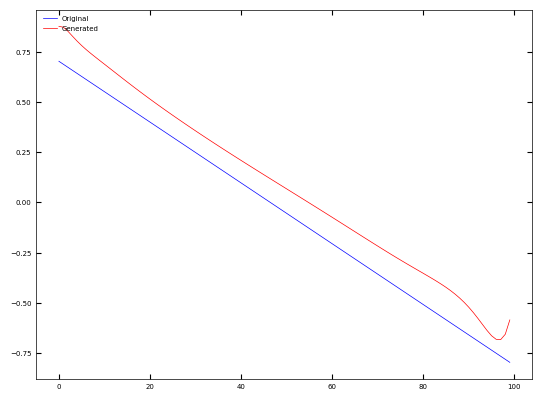

In [59]:
(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)
rand = np.random.randint(0, 500)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
#plt.plot(decoded_[rand, :, 0], "r", label="Generated")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()

In [60]:
latent_dim_two = 12

encoder_two = Encoder(latent_dim=latent_dim_two).to(device)
decoder_two = Decoder(latent_dim=latent_dim_two).to(device)
model_two = Autoencoder(encoder_two, decoder_two).to(device)

optimizer_two = optim.Adam(model_two.parameters(), lr=5e-5)

In [61]:
torch.manual_seed(0)
Train(model_two, encoder_two, decoder_two, dataloader, optimizer_two, 1000,)

100%|██████████| 20/20 [00:00<00:00, 87.17it/s]


Epoch 0, Train Loss: 0.4431
.............................


100%|██████████| 20/20 [00:00<00:00, 151.42it/s]


Epoch 1, Train Loss: 0.4428
.............................


100%|██████████| 20/20 [00:00<00:00, 172.55it/s]


Epoch 2, Train Loss: 0.4426
.............................


100%|██████████| 20/20 [00:00<00:00, 84.77it/s]


Epoch 3, Train Loss: 0.4424
.............................


100%|██████████| 20/20 [00:00<00:00, 72.04it/s]


Epoch 4, Train Loss: 0.4422
.............................


100%|██████████| 20/20 [00:00<00:00, 128.97it/s]


Epoch 5, Train Loss: 0.4420
.............................


100%|██████████| 20/20 [00:00<00:00, 71.75it/s]


Epoch 6, Train Loss: 0.4417
.............................


100%|██████████| 20/20 [00:00<00:00, 79.17it/s]


Epoch 7, Train Loss: 0.4413
.............................


100%|██████████| 20/20 [00:00<00:00, 135.19it/s]


Epoch 8, Train Loss: 0.4409
.............................


100%|██████████| 20/20 [00:00<00:00, 74.13it/s]


Epoch 9, Train Loss: 0.4403
.............................


100%|██████████| 20/20 [00:00<00:00, 72.37it/s]


Epoch 10, Train Loss: 0.4395
.............................


100%|██████████| 20/20 [00:00<00:00, 119.80it/s]


Epoch 11, Train Loss: 0.4385
.............................


100%|██████████| 20/20 [00:00<00:00, 161.27it/s]


Epoch 12, Train Loss: 0.4373
.............................


100%|██████████| 20/20 [00:00<00:00, 88.32it/s] 


Epoch 13, Train Loss: 0.4355
.............................


100%|██████████| 20/20 [00:00<00:00, 106.07it/s]


Epoch 14, Train Loss: 0.4333
.............................


100%|██████████| 20/20 [00:00<00:00, 102.78it/s]


Epoch 15, Train Loss: 0.4302
.............................


100%|██████████| 20/20 [00:00<00:00, 144.87it/s]


Epoch 16, Train Loss: 0.4259
.............................


100%|██████████| 20/20 [00:00<00:00, 186.19it/s]


Epoch 17, Train Loss: 0.4201
.............................


100%|██████████| 20/20 [00:00<00:00, 194.59it/s]


Epoch 18, Train Loss: 0.4121
.............................


100%|██████████| 20/20 [00:00<00:00, 93.40it/s] 


Epoch 19, Train Loss: 0.4013
.............................


100%|██████████| 20/20 [00:00<00:00, 91.33it/s]


Epoch 20, Train Loss: 0.3870
.............................


100%|██████████| 20/20 [00:00<00:00, 123.97it/s]


Epoch 21, Train Loss: 0.3689
.............................


100%|██████████| 20/20 [00:00<00:00, 106.58it/s]


Epoch 22, Train Loss: 0.3473
.............................


100%|██████████| 20/20 [00:00<00:00, 171.55it/s]


Epoch 23, Train Loss: 0.3246
.............................


100%|██████████| 20/20 [00:00<00:00, 121.99it/s]


Epoch 24, Train Loss: 0.3040
.............................


100%|██████████| 20/20 [00:00<00:00, 74.88it/s]


Epoch 25, Train Loss: 0.2890
.............................


100%|██████████| 20/20 [00:00<00:00, 153.04it/s]


Epoch 26, Train Loss: 0.2804
.............................


100%|██████████| 20/20 [00:00<00:00, 195.16it/s]


Epoch 27, Train Loss: 0.2769
.............................


100%|██████████| 20/20 [00:00<00:00, 195.91it/s]


Epoch 28, Train Loss: 0.2755
.............................


100%|██████████| 20/20 [00:00<00:00, 110.90it/s]


Epoch 29, Train Loss: 0.2745
.............................


100%|██████████| 20/20 [00:00<00:00, 133.05it/s]


Epoch 30, Train Loss: 0.2736
.............................


100%|██████████| 20/20 [00:00<00:00, 90.94it/s] 


Epoch 31, Train Loss: 0.2727
.............................


100%|██████████| 20/20 [00:00<00:00, 108.33it/s]


Epoch 32, Train Loss: 0.2716
.............................


100%|██████████| 20/20 [00:00<00:00, 109.37it/s]


Epoch 33, Train Loss: 0.2705
.............................


100%|██████████| 20/20 [00:00<00:00, 153.52it/s]


Epoch 34, Train Loss: 0.2692
.............................


100%|██████████| 20/20 [00:00<00:00, 100.85it/s]


Epoch 35, Train Loss: 0.2676
.............................


100%|██████████| 20/20 [00:00<00:00, 76.38it/s]


Epoch 36, Train Loss: 0.2658
.............................


100%|██████████| 20/20 [00:00<00:00, 93.02it/s]


Epoch 37, Train Loss: 0.2635
.............................


100%|██████████| 20/20 [00:00<00:00, 139.89it/s]


Epoch 38, Train Loss: 0.2604
.............................


100%|██████████| 20/20 [00:00<00:00, 77.77it/s]


Epoch 39, Train Loss: 0.2562
.............................


100%|██████████| 20/20 [00:00<00:00, 99.32it/s]


Epoch 40, Train Loss: 0.2501
.............................


100%|██████████| 20/20 [00:00<00:00, 84.31it/s]


Epoch 41, Train Loss: 0.2408
.............................


100%|██████████| 20/20 [00:00<00:00, 176.20it/s]


Epoch 42, Train Loss: 0.2272
.............................


100%|██████████| 20/20 [00:00<00:00, 116.78it/s]


Epoch 43, Train Loss: 0.2091
.............................


100%|██████████| 20/20 [00:00<00:00, 54.07it/s]


Epoch 44, Train Loss: 0.1913
.............................


100%|██████████| 20/20 [00:00<00:00, 133.26it/s]


Epoch 45, Train Loss: 0.1796
.............................


100%|██████████| 20/20 [00:00<00:00, 70.17it/s]


Epoch 46, Train Loss: 0.1744
.............................


100%|██████████| 20/20 [00:00<00:00, 103.99it/s]


Epoch 47, Train Loss: 0.1726
.............................


100%|██████████| 20/20 [00:00<00:00, 146.38it/s]


Epoch 48, Train Loss: 0.1717
.............................


100%|██████████| 20/20 [00:00<00:00, 71.49it/s] 


Epoch 49, Train Loss: 0.1708
.............................


100%|██████████| 20/20 [00:00<00:00, 101.10it/s]


Epoch 50, Train Loss: 0.1700
.............................


100%|██████████| 20/20 [00:00<00:00, 91.78it/s]


Epoch 51, Train Loss: 0.1693
.............................


100%|██████████| 20/20 [00:00<00:00, 176.29it/s]


Epoch 52, Train Loss: 0.1701
.............................


100%|██████████| 20/20 [00:00<00:00, 189.16it/s]


Epoch 53, Train Loss: 0.1688
.............................


100%|██████████| 20/20 [00:00<00:00, 190.65it/s]


Epoch 54, Train Loss: 0.1690
.............................


100%|██████████| 20/20 [00:00<00:00, 80.72it/s] 


Epoch 55, Train Loss: 0.1719
.............................


100%|██████████| 20/20 [00:00<00:00, 104.25it/s]


Epoch 56, Train Loss: 0.1691
.............................


100%|██████████| 20/20 [00:00<00:00, 86.94it/s] 


Epoch 57, Train Loss: 0.1677
.............................


100%|██████████| 20/20 [00:00<00:00, 131.80it/s]


Epoch 58, Train Loss: 0.1672
.............................


100%|██████████| 20/20 [00:00<00:00, 102.94it/s]


Epoch 59, Train Loss: 0.1668
.............................


100%|██████████| 20/20 [00:00<00:00, 73.81it/s]


Epoch 60, Train Loss: 0.1664
.............................


100%|██████████| 20/20 [00:00<00:00, 81.18it/s] 


Epoch 61, Train Loss: 0.1661
.............................


100%|██████████| 20/20 [00:00<00:00, 146.91it/s]


Epoch 62, Train Loss: 0.1657
.............................


100%|██████████| 20/20 [00:00<00:00, 188.50it/s]


Epoch 63, Train Loss: 0.1653
.............................


100%|██████████| 20/20 [00:00<00:00, 103.67it/s]


Epoch 64, Train Loss: 0.1650
.............................


100%|██████████| 20/20 [00:00<00:00, 50.61it/s]


Epoch 65, Train Loss: 0.1647
.............................


100%|██████████| 20/20 [00:00<00:00, 173.25it/s]


Epoch 66, Train Loss: 0.1645
.............................


100%|██████████| 20/20 [00:00<00:00, 109.06it/s]


Epoch 67, Train Loss: 0.1646
.............................


100%|██████████| 20/20 [00:00<00:00, 57.67it/s]


Epoch 68, Train Loss: 0.1681
.............................


100%|██████████| 20/20 [00:00<00:00, 132.89it/s]


Epoch 69, Train Loss: 0.1674
.............................


100%|██████████| 20/20 [00:00<00:00, 177.13it/s]


Epoch 70, Train Loss: 0.1666
.............................


100%|██████████| 20/20 [00:00<00:00, 74.36it/s] 


Epoch 71, Train Loss: 0.1658
.............................


100%|██████████| 20/20 [00:00<00:00, 59.14it/s]


Epoch 72, Train Loss: 0.1653
.............................


100%|██████████| 20/20 [00:00<00:00, 170.24it/s]


Epoch 73, Train Loss: 0.1651
.............................


100%|██████████| 20/20 [00:00<00:00, 129.11it/s]


Epoch 74, Train Loss: 0.1647
.............................


100%|██████████| 20/20 [00:00<00:00, 68.71it/s]


Epoch 75, Train Loss: 0.1643
.............................


100%|██████████| 20/20 [00:00<00:00, 109.46it/s]


Epoch 76, Train Loss: 0.1635
.............................


100%|██████████| 20/20 [00:00<00:00, 81.94it/s]


Epoch 77, Train Loss: 0.1626
.............................


100%|██████████| 20/20 [00:00<00:00, 179.34it/s]


Epoch 78, Train Loss: 0.1623
.............................


100%|██████████| 20/20 [00:00<00:00, 128.69it/s]


Epoch 79, Train Loss: 0.1620
.............................


100%|██████████| 20/20 [00:00<00:00, 71.49it/s]


Epoch 80, Train Loss: 0.1618
.............................


100%|██████████| 20/20 [00:00<00:00, 91.69it/s]


Epoch 81, Train Loss: 0.1615
.............................


100%|██████████| 20/20 [00:00<00:00, 176.52it/s]


Epoch 82, Train Loss: 0.1613
.............................


100%|██████████| 20/20 [00:00<00:00, 146.64it/s]


Epoch 83, Train Loss: 0.1611
.............................


100%|██████████| 20/20 [00:00<00:00, 57.43it/s]


Epoch 84, Train Loss: 0.1608
.............................


100%|██████████| 20/20 [00:00<00:00, 127.32it/s]


Epoch 85, Train Loss: 0.1605
.............................


100%|██████████| 20/20 [00:00<00:00, 174.93it/s]


Epoch 86, Train Loss: 0.1602
.............................


100%|██████████| 20/20 [00:00<00:00, 118.13it/s]


Epoch 87, Train Loss: 0.1600
.............................


100%|██████████| 20/20 [00:00<00:00, 73.93it/s]


Epoch 88, Train Loss: 0.1597
.............................


100%|██████████| 20/20 [00:00<00:00, 120.88it/s]


Epoch 89, Train Loss: 0.1595
.............................


100%|██████████| 20/20 [00:00<00:00, 120.24it/s]


Epoch 90, Train Loss: 0.1593
.............................


100%|██████████| 20/20 [00:00<00:00, 138.33it/s]


Epoch 91, Train Loss: 0.1591
.............................


100%|██████████| 20/20 [00:00<00:00, 180.01it/s]


Epoch 92, Train Loss: 0.1590
.............................


100%|██████████| 20/20 [00:00<00:00, 168.66it/s]


Epoch 93, Train Loss: 0.1588
.............................


100%|██████████| 20/20 [00:00<00:00, 87.48it/s]


Epoch 94, Train Loss: 0.1585
.............................


100%|██████████| 20/20 [00:00<00:00, 89.60it/s]


Epoch 95, Train Loss: 0.1584
.............................


100%|██████████| 20/20 [00:00<00:00, 125.18it/s]


Epoch 96, Train Loss: 0.1582
.............................


100%|██████████| 20/20 [00:00<00:00, 131.89it/s]


Epoch 97, Train Loss: 0.1580
.............................


100%|██████████| 20/20 [00:00<00:00, 141.35it/s]


Epoch 98, Train Loss: 0.1578
.............................


100%|██████████| 20/20 [00:00<00:00, 88.41it/s]


Epoch 99, Train Loss: 0.1575
.............................


100%|██████████| 20/20 [00:00<00:00, 96.87it/s]


Epoch 100, Train Loss: 0.1573
.............................


100%|██████████| 20/20 [00:00<00:00, 125.91it/s]


Epoch 101, Train Loss: 0.1571
.............................


100%|██████████| 20/20 [00:00<00:00, 171.11it/s]


Epoch 102, Train Loss: 0.1569
.............................


100%|██████████| 20/20 [00:00<00:00, 149.29it/s]


Epoch 103, Train Loss: 0.1566
.............................


100%|██████████| 20/20 [00:00<00:00, 60.80it/s]


Epoch 104, Train Loss: 0.1564
.............................


100%|██████████| 20/20 [00:00<00:00, 89.41it/s] 


Epoch 105, Train Loss: 0.1562
.............................


100%|██████████| 20/20 [00:00<00:00, 152.25it/s]


Epoch 106, Train Loss: 0.1560
.............................


100%|██████████| 20/20 [00:00<00:00, 165.28it/s]


Epoch 107, Train Loss: 0.1558
.............................


100%|██████████| 20/20 [00:00<00:00, 83.95it/s] 


Epoch 108, Train Loss: 0.1555
.............................


100%|██████████| 20/20 [00:00<00:00, 54.12it/s]


Epoch 109, Train Loss: 0.1553
.............................


100%|██████████| 20/20 [00:00<00:00, 86.02it/s]


Epoch 110, Train Loss: 0.1551
.............................


100%|██████████| 20/20 [00:00<00:00, 91.01it/s] 


Epoch 111, Train Loss: 0.1549
.............................


100%|██████████| 20/20 [00:00<00:00, 162.75it/s]


Epoch 112, Train Loss: 0.1546
.............................


100%|██████████| 20/20 [00:00<00:00, 183.40it/s]


Epoch 113, Train Loss: 0.1546
.............................


100%|██████████| 20/20 [00:00<00:00, 151.00it/s]


Epoch 114, Train Loss: 0.1548
.............................


100%|██████████| 20/20 [00:00<00:00, 77.16it/s]


Epoch 115, Train Loss: 0.1545
.............................


100%|██████████| 20/20 [00:00<00:00, 145.42it/s]


Epoch 116, Train Loss: 0.1542
.............................


100%|██████████| 20/20 [00:00<00:00, 181.99it/s]


Epoch 117, Train Loss: 0.1538
.............................


100%|██████████| 20/20 [00:00<00:00, 155.07it/s]


Epoch 118, Train Loss: 0.1534
.............................


100%|██████████| 20/20 [00:00<00:00, 94.62it/s] 


Epoch 119, Train Loss: 0.1531
.............................


100%|██████████| 20/20 [00:00<00:00, 156.56it/s]


Epoch 120, Train Loss: 0.1529
.............................


100%|██████████| 20/20 [00:00<00:00, 96.25it/s] 


Epoch 121, Train Loss: 0.1526
.............................


100%|██████████| 20/20 [00:00<00:00, 104.15it/s]


Epoch 122, Train Loss: 0.1524
.............................


100%|██████████| 20/20 [00:00<00:00, 196.23it/s]


Epoch 123, Train Loss: 0.1521
.............................


100%|██████████| 20/20 [00:00<00:00, 150.02it/s]


Epoch 124, Train Loss: 0.1517
.............................


100%|██████████| 20/20 [00:00<00:00, 125.46it/s]


Epoch 125, Train Loss: 0.1513
.............................


100%|██████████| 20/20 [00:00<00:00, 180.33it/s]


Epoch 126, Train Loss: 0.1510
.............................


100%|██████████| 20/20 [00:00<00:00, 189.67it/s]


Epoch 127, Train Loss: 0.1506
.............................


100%|██████████| 20/20 [00:00<00:00, 100.84it/s]


Epoch 128, Train Loss: 0.1501
.............................


100%|██████████| 20/20 [00:00<00:00, 74.65it/s]


Epoch 129, Train Loss: 0.1496
.............................


100%|██████████| 20/20 [00:00<00:00, 84.68it/s]


Epoch 130, Train Loss: 0.1490
.............................


100%|██████████| 20/20 [00:00<00:00, 151.77it/s]


Epoch 131, Train Loss: 0.1484
.............................


100%|██████████| 20/20 [00:00<00:00, 95.99it/s] 


Epoch 132, Train Loss: 0.1477
.............................


100%|██████████| 20/20 [00:00<00:00, 72.28it/s]


Epoch 133, Train Loss: 0.1469
.............................


100%|██████████| 20/20 [00:00<00:00, 125.32it/s]


Epoch 134, Train Loss: 0.1461
.............................


100%|██████████| 20/20 [00:00<00:00, 158.56it/s]


Epoch 135, Train Loss: 0.1449
.............................


100%|██████████| 20/20 [00:00<00:00, 166.07it/s]


Epoch 136, Train Loss: 0.1437
.............................


100%|██████████| 20/20 [00:00<00:00, 80.36it/s]


Epoch 137, Train Loss: 0.1420
.............................


100%|██████████| 20/20 [00:00<00:00, 80.30it/s]


Epoch 138, Train Loss: 0.1399
.............................


100%|██████████| 20/20 [00:00<00:00, 140.37it/s]


Epoch 139, Train Loss: 0.1371
.............................


100%|██████████| 20/20 [00:00<00:00, 71.46it/s] 


Epoch 140, Train Loss: 0.1334
.............................


100%|██████████| 20/20 [00:00<00:00, 71.55it/s]


Epoch 141, Train Loss: 0.1286
.............................


100%|██████████| 20/20 [00:00<00:00, 131.49it/s]


Epoch 142, Train Loss: 0.1237
.............................


100%|██████████| 20/20 [00:00<00:00, 110.85it/s]


Epoch 143, Train Loss: 0.1201
.............................


100%|██████████| 20/20 [00:00<00:00, 71.12it/s]


Epoch 144, Train Loss: 0.1178
.............................


100%|██████████| 20/20 [00:00<00:00, 112.19it/s]


Epoch 145, Train Loss: 0.1157
.............................


100%|██████████| 20/20 [00:00<00:00, 81.68it/s]


Epoch 146, Train Loss: 0.1138
.............................


100%|██████████| 20/20 [00:00<00:00, 180.13it/s]


Epoch 147, Train Loss: 0.1124
.............................


100%|██████████| 20/20 [00:00<00:00, 166.27it/s]


Epoch 148, Train Loss: 0.1108
.............................


100%|██████████| 20/20 [00:00<00:00, 77.56it/s] 


Epoch 149, Train Loss: 0.1094
.............................


100%|██████████| 20/20 [00:00<00:00, 63.60it/s]


Epoch 150, Train Loss: 0.1079
.............................


100%|██████████| 20/20 [00:00<00:00, 119.24it/s]


Epoch 151, Train Loss: 0.1065
.............................


100%|██████████| 20/20 [00:00<00:00, 168.96it/s]


Epoch 152, Train Loss: 0.1051
.............................


100%|██████████| 20/20 [00:00<00:00, 70.19it/s] 


Epoch 153, Train Loss: 0.1037
.............................


100%|██████████| 20/20 [00:00<00:00, 65.51it/s]


Epoch 154, Train Loss: 0.1027
.............................


100%|██████████| 20/20 [00:00<00:00, 75.63it/s]


Epoch 155, Train Loss: 0.1020
.............................


100%|██████████| 20/20 [00:00<00:00, 185.39it/s]


Epoch 156, Train Loss: 0.1008
.............................


100%|██████████| 20/20 [00:00<00:00, 190.46it/s]


Epoch 157, Train Loss: 0.0990
.............................


100%|██████████| 20/20 [00:00<00:00, 68.10it/s] 


Epoch 158, Train Loss: 0.0969
.............................


100%|██████████| 20/20 [00:00<00:00, 63.85it/s]


Epoch 159, Train Loss: 0.0948
.............................


100%|██████████| 20/20 [00:00<00:00, 140.76it/s]


Epoch 160, Train Loss: 0.0933
.............................


100%|██████████| 20/20 [00:00<00:00, 63.87it/s]


Epoch 161, Train Loss: 0.0934
.............................


100%|██████████| 20/20 [00:00<00:00, 69.56it/s]


Epoch 162, Train Loss: 0.0915
.............................


100%|██████████| 20/20 [00:00<00:00, 148.26it/s]


Epoch 163, Train Loss: 0.0888
.............................


100%|██████████| 20/20 [00:00<00:00, 67.50it/s]


Epoch 164, Train Loss: 0.1035
.............................


100%|██████████| 20/20 [00:00<00:00, 63.25it/s]


Epoch 165, Train Loss: 0.1176
.............................


100%|██████████| 20/20 [00:00<00:00, 156.42it/s]


Epoch 166, Train Loss: 0.1113
.............................


100%|██████████| 20/20 [00:00<00:00, 166.71it/s]


Epoch 167, Train Loss: 0.1066
.............................


100%|██████████| 20/20 [00:00<00:00, 107.04it/s]


Epoch 168, Train Loss: 0.1040
.............................


100%|██████████| 20/20 [00:00<00:00, 92.11it/s]


Epoch 169, Train Loss: 0.1022
.............................


100%|██████████| 20/20 [00:00<00:00, 103.55it/s]


Epoch 170, Train Loss: 0.1063
.............................


100%|██████████| 20/20 [00:00<00:00, 149.81it/s]


Epoch 171, Train Loss: 0.1039
.............................


100%|██████████| 20/20 [00:00<00:00, 70.84it/s] 


Epoch 172, Train Loss: 0.1016
.............................


100%|██████████| 20/20 [00:00<00:00, 75.29it/s]


Epoch 173, Train Loss: 0.1000
.............................


100%|██████████| 20/20 [00:00<00:00, 172.30it/s]


Epoch 174, Train Loss: 0.0999
.............................


100%|██████████| 20/20 [00:00<00:00, 103.18it/s]


Epoch 175, Train Loss: 0.1004
.............................


100%|██████████| 20/20 [00:00<00:00, 45.32it/s]


Epoch 176, Train Loss: 0.0998
.............................


100%|██████████| 20/20 [00:00<00:00, 164.94it/s]


Epoch 177, Train Loss: 0.0990
.............................


100%|██████████| 20/20 [00:00<00:00, 104.91it/s]


Epoch 178, Train Loss: 0.0980
.............................


100%|██████████| 20/20 [00:00<00:00, 68.24it/s]


Epoch 179, Train Loss: 0.0976
.............................


100%|██████████| 20/20 [00:00<00:00, 88.01it/s]


Epoch 180, Train Loss: 0.0977
.............................


100%|██████████| 20/20 [00:00<00:00, 149.19it/s]


Epoch 181, Train Loss: 0.0973
.............................


100%|██████████| 20/20 [00:00<00:00, 78.68it/s]


Epoch 182, Train Loss: 0.0968
.............................


100%|██████████| 20/20 [00:00<00:00, 81.03it/s]


Epoch 183, Train Loss: 0.0968
.............................


100%|██████████| 20/20 [00:00<00:00, 131.51it/s]


Epoch 184, Train Loss: 0.0967
.............................


100%|██████████| 20/20 [00:00<00:00, 84.73it/s]


Epoch 185, Train Loss: 0.0971
.............................


100%|██████████| 20/20 [00:00<00:00, 91.81it/s]


Epoch 186, Train Loss: 0.0968
.............................


100%|██████████| 20/20 [00:00<00:00, 71.86it/s]


Epoch 187, Train Loss: 0.0961
.............................


100%|██████████| 20/20 [00:00<00:00, 152.98it/s]


Epoch 188, Train Loss: 0.0964
.............................


100%|██████████| 20/20 [00:00<00:00, 75.78it/s] 


Epoch 189, Train Loss: 0.0973
.............................


100%|██████████| 20/20 [00:00<00:00, 74.08it/s]


Epoch 190, Train Loss: 0.0968
.............................


100%|██████████| 20/20 [00:00<00:00, 161.92it/s]


Epoch 191, Train Loss: 0.0976
.............................


100%|██████████| 20/20 [00:00<00:00, 98.71it/s] 


Epoch 192, Train Loss: 0.0957
.............................


100%|██████████| 20/20 [00:00<00:00, 55.70it/s]


Epoch 193, Train Loss: 0.0952
.............................


100%|██████████| 20/20 [00:00<00:00, 166.88it/s]


Epoch 194, Train Loss: 0.0952
.............................


100%|██████████| 20/20 [00:00<00:00, 159.87it/s]


Epoch 195, Train Loss: 0.0949
.............................


100%|██████████| 20/20 [00:00<00:00, 48.05it/s]


Epoch 196, Train Loss: 0.0948
.............................


100%|██████████| 20/20 [00:00<00:00, 130.37it/s]


Epoch 197, Train Loss: 0.0947
.............................


100%|██████████| 20/20 [00:00<00:00, 177.24it/s]


Epoch 198, Train Loss: 0.0946
.............................


100%|██████████| 20/20 [00:00<00:00, 108.16it/s]


Epoch 199, Train Loss: 0.0946
.............................


100%|██████████| 20/20 [00:00<00:00, 49.62it/s]


Epoch 200, Train Loss: 0.0945
.............................


100%|██████████| 20/20 [00:00<00:00, 163.91it/s]


Epoch 201, Train Loss: 0.0942
.............................


100%|██████████| 20/20 [00:00<00:00, 143.30it/s]


Epoch 202, Train Loss: 0.0931
.............................


100%|██████████| 20/20 [00:00<00:00, 70.52it/s]


Epoch 203, Train Loss: 0.0927
.............................


100%|██████████| 20/20 [00:00<00:00, 82.38it/s]


Epoch 204, Train Loss: 0.0926
.............................


100%|██████████| 20/20 [00:00<00:00, 168.00it/s]


Epoch 205, Train Loss: 0.0925
.............................


100%|██████████| 20/20 [00:00<00:00, 129.55it/s]


Epoch 206, Train Loss: 0.0924
.............................


100%|██████████| 20/20 [00:00<00:00, 61.21it/s]


Epoch 207, Train Loss: 0.0924
.............................


100%|██████████| 20/20 [00:00<00:00, 70.74it/s]


Epoch 208, Train Loss: 0.0923
.............................


100%|██████████| 20/20 [00:00<00:00, 154.37it/s]


Epoch 209, Train Loss: 0.0922
.............................


100%|██████████| 20/20 [00:00<00:00, 98.75it/s] 


Epoch 210, Train Loss: 0.0922
.............................


100%|██████████| 20/20 [00:00<00:00, 53.15it/s]


Epoch 211, Train Loss: 0.0927
.............................


100%|██████████| 20/20 [00:00<00:00, 167.54it/s]


Epoch 212, Train Loss: 0.0923
.............................


100%|██████████| 20/20 [00:00<00:00, 172.53it/s]


Epoch 213, Train Loss: 0.0922
.............................


100%|██████████| 20/20 [00:00<00:00, 125.55it/s]


Epoch 214, Train Loss: 0.0922
.............................


100%|██████████| 20/20 [00:00<00:00, 73.06it/s]


Epoch 215, Train Loss: 0.0926
.............................


100%|██████████| 20/20 [00:00<00:00, 99.75it/s] 


Epoch 216, Train Loss: 0.0923
.............................


100%|██████████| 20/20 [00:00<00:00, 172.51it/s]


Epoch 217, Train Loss: 0.0930
.............................


100%|██████████| 20/20 [00:00<00:00, 157.26it/s]


Epoch 218, Train Loss: 0.0926
.............................


100%|██████████| 20/20 [00:00<00:00, 62.76it/s]


Epoch 219, Train Loss: 0.0917
.............................


100%|██████████| 20/20 [00:00<00:00, 78.01it/s]


Epoch 220, Train Loss: 0.0915
.............................


100%|██████████| 20/20 [00:00<00:00, 58.54it/s]


Epoch 221, Train Loss: 0.0914
.............................


100%|██████████| 20/20 [00:00<00:00, 78.00it/s]


Epoch 222, Train Loss: 0.0914
.............................


100%|██████████| 20/20 [00:00<00:00, 121.01it/s]


Epoch 223, Train Loss: 0.0912
.............................


100%|██████████| 20/20 [00:00<00:00, 52.91it/s]


Epoch 224, Train Loss: 0.0914
.............................


100%|██████████| 20/20 [00:00<00:00, 60.68it/s]


Epoch 225, Train Loss: 0.0918
.............................


100%|██████████| 20/20 [00:00<00:00, 46.18it/s]


Epoch 226, Train Loss: 0.0918
.............................


100%|██████████| 20/20 [00:00<00:00, 137.71it/s]


Epoch 227, Train Loss: 0.0912
.............................


100%|██████████| 20/20 [00:00<00:00, 80.62it/s] 


Epoch 228, Train Loss: 0.0911
.............................


100%|██████████| 20/20 [00:00<00:00, 77.22it/s]


Epoch 229, Train Loss: 0.0910
.............................


100%|██████████| 20/20 [00:00<00:00, 72.95it/s]


Epoch 230, Train Loss: 0.0908
.............................


100%|██████████| 20/20 [00:00<00:00, 131.05it/s]


Epoch 231, Train Loss: 0.0907
.............................


100%|██████████| 20/20 [00:00<00:00, 56.97it/s]


Epoch 232, Train Loss: 0.0908
.............................


100%|██████████| 20/20 [00:00<00:00, 79.60it/s]


Epoch 233, Train Loss: 0.0910
.............................


100%|██████████| 20/20 [00:00<00:00, 123.81it/s]


Epoch 234, Train Loss: 0.0907
.............................


100%|██████████| 20/20 [00:00<00:00, 173.01it/s]


Epoch 235, Train Loss: 0.0904
.............................


100%|██████████| 20/20 [00:00<00:00, 126.55it/s]


Epoch 236, Train Loss: 0.0904
.............................


100%|██████████| 20/20 [00:00<00:00, 49.59it/s]


Epoch 237, Train Loss: 0.0903
.............................


100%|██████████| 20/20 [00:00<00:00, 170.61it/s]


Epoch 238, Train Loss: 0.0904
.............................


100%|██████████| 20/20 [00:00<00:00, 171.15it/s]


Epoch 239, Train Loss: 0.0904
.............................


100%|██████████| 20/20 [00:00<00:00, 105.10it/s]


Epoch 240, Train Loss: 0.0903
.............................


100%|██████████| 20/20 [00:00<00:00, 41.89it/s]


Epoch 241, Train Loss: 0.0900
.............................


100%|██████████| 20/20 [00:00<00:00, 165.63it/s]


Epoch 242, Train Loss: 0.0901
.............................


100%|██████████| 20/20 [00:00<00:00, 95.09it/s] 


Epoch 243, Train Loss: 0.0901
.............................


100%|██████████| 20/20 [00:00<00:00, 81.12it/s]


Epoch 244, Train Loss: 0.0898
.............................


100%|██████████| 20/20 [00:00<00:00, 81.20it/s]


Epoch 245, Train Loss: 0.0899
.............................


100%|██████████| 20/20 [00:00<00:00, 177.10it/s]


Epoch 246, Train Loss: 0.0897
.............................


100%|██████████| 20/20 [00:00<00:00, 168.40it/s]


Epoch 247, Train Loss: 0.0902
.............................


100%|██████████| 20/20 [00:00<00:00, 66.26it/s]


Epoch 248, Train Loss: 0.0896
.............................


100%|██████████| 20/20 [00:00<00:00, 96.25it/s] 


Epoch 249, Train Loss: 0.0893
.............................


100%|██████████| 20/20 [00:00<00:00, 108.18it/s]


Epoch 250, Train Loss: 0.0896
.............................


100%|██████████| 20/20 [00:00<00:00, 118.69it/s]


Epoch 251, Train Loss: 0.0891
.............................


100%|██████████| 20/20 [00:00<00:00, 72.74it/s]


Epoch 252, Train Loss: 0.0890
.............................


100%|██████████| 20/20 [00:00<00:00, 94.68it/s] 


Epoch 253, Train Loss: 0.0894
.............................


100%|██████████| 20/20 [00:00<00:00, 122.96it/s]


Epoch 254, Train Loss: 0.0904
.............................


100%|██████████| 20/20 [00:00<00:00, 146.26it/s]


Epoch 255, Train Loss: 0.0896
.............................


100%|██████████| 20/20 [00:00<00:00, 68.17it/s]


Epoch 256, Train Loss: 0.0887
.............................


100%|██████████| 20/20 [00:00<00:00, 115.82it/s]


Epoch 257, Train Loss: 0.0889
.............................


100%|██████████| 20/20 [00:00<00:00, 90.87it/s]


Epoch 258, Train Loss: 0.0885
.............................


100%|██████████| 20/20 [00:00<00:00, 165.35it/s]


Epoch 259, Train Loss: 0.0881
.............................


100%|██████████| 20/20 [00:00<00:00, 132.25it/s]


Epoch 260, Train Loss: 0.0876
.............................


100%|██████████| 20/20 [00:00<00:00, 75.27it/s]


Epoch 261, Train Loss: 0.0875
.............................


100%|██████████| 20/20 [00:00<00:00, 136.29it/s]


Epoch 262, Train Loss: 0.0873
.............................


100%|██████████| 20/20 [00:00<00:00, 94.85it/s] 


Epoch 263, Train Loss: 0.0871
.............................


100%|██████████| 20/20 [00:00<00:00, 115.61it/s]


Epoch 264, Train Loss: 0.0884
.............................


100%|██████████| 20/20 [00:00<00:00, 67.86it/s]


Epoch 265, Train Loss: 0.0879
.............................


100%|██████████| 20/20 [00:00<00:00, 82.10it/s] 


Epoch 266, Train Loss: 0.0867
.............................


100%|██████████| 20/20 [00:00<00:00, 142.64it/s]


Epoch 267, Train Loss: 0.0859
.............................


100%|██████████| 20/20 [00:00<00:00, 122.71it/s]


Epoch 268, Train Loss: 0.0856
.............................


100%|██████████| 20/20 [00:00<00:00, 49.73it/s]


Epoch 269, Train Loss: 0.0850
.............................


100%|██████████| 20/20 [00:00<00:00, 146.72it/s]


Epoch 270, Train Loss: 0.0901
.............................


100%|██████████| 20/20 [00:00<00:00, 172.53it/s]


Epoch 271, Train Loss: 0.0916
.............................


100%|██████████| 20/20 [00:00<00:00, 92.26it/s] 


Epoch 272, Train Loss: 0.0856
.............................


100%|██████████| 20/20 [00:00<00:00, 97.40it/s]


Epoch 273, Train Loss: 0.0837
.............................


100%|██████████| 20/20 [00:00<00:00, 96.43it/s]


Epoch 274, Train Loss: 0.0839
.............................


100%|██████████| 20/20 [00:00<00:00, 176.95it/s]


Epoch 275, Train Loss: 0.0823
.............................


100%|██████████| 20/20 [00:00<00:00, 123.72it/s]


Epoch 276, Train Loss: 0.0882
.............................


100%|██████████| 20/20 [00:00<00:00, 49.66it/s]


Epoch 277, Train Loss: 0.0829
.............................


100%|██████████| 20/20 [00:00<00:00, 72.31it/s]


Epoch 278, Train Loss: 0.0785
.............................


100%|██████████| 20/20 [00:00<00:00, 59.07it/s]


Epoch 279, Train Loss: 0.0853
.............................


100%|██████████| 20/20 [00:00<00:00, 136.89it/s]


Epoch 280, Train Loss: 0.0888
.............................


100%|██████████| 20/20 [00:00<00:00, 164.51it/s]


Epoch 281, Train Loss: 0.0802
.............................


100%|██████████| 20/20 [00:00<00:00, 81.37it/s]


Epoch 282, Train Loss: 0.0777
.............................


100%|██████████| 20/20 [00:00<00:00, 93.81it/s]


Epoch 283, Train Loss: 0.0813
.............................


100%|██████████| 20/20 [00:00<00:00, 105.07it/s]


Epoch 284, Train Loss: 0.0747
.............................


100%|██████████| 20/20 [00:00<00:00, 175.58it/s]


Epoch 285, Train Loss: 0.0714
.............................


100%|██████████| 20/20 [00:00<00:00, 169.30it/s]


Epoch 286, Train Loss: 0.0692
.............................


100%|██████████| 20/20 [00:00<00:00, 94.28it/s] 


Epoch 287, Train Loss: 0.0900
.............................


100%|██████████| 20/20 [00:00<00:00, 90.27it/s]


Epoch 288, Train Loss: 0.0774
.............................


100%|██████████| 20/20 [00:00<00:00, 120.37it/s]


Epoch 289, Train Loss: 0.0677
.............................


100%|██████████| 20/20 [00:00<00:00, 144.13it/s]


Epoch 290, Train Loss: 0.0655
.............................


100%|██████████| 20/20 [00:00<00:00, 88.68it/s] 


Epoch 291, Train Loss: 0.0688
.............................


100%|██████████| 20/20 [00:00<00:00, 98.99it/s]


Epoch 292, Train Loss: 0.0666
.............................


100%|██████████| 20/20 [00:00<00:00, 120.82it/s]


Epoch 293, Train Loss: 0.0686
.............................


100%|██████████| 20/20 [00:00<00:00, 96.41it/s]


Epoch 294, Train Loss: 0.0632
.............................


100%|██████████| 20/20 [00:00<00:00, 182.81it/s]


Epoch 295, Train Loss: 0.0624
.............................


100%|██████████| 20/20 [00:00<00:00, 120.63it/s]


Epoch 296, Train Loss: 0.0629
.............................


100%|██████████| 20/20 [00:00<00:00, 50.67it/s]


Epoch 297, Train Loss: 0.0643
.............................


100%|██████████| 20/20 [00:00<00:00, 146.91it/s]


Epoch 298, Train Loss: 0.0642
.............................


100%|██████████| 20/20 [00:00<00:00, 68.74it/s]


Epoch 299, Train Loss: 0.0611
.............................


100%|██████████| 20/20 [00:00<00:00, 89.33it/s] 


Epoch 300, Train Loss: 0.0612
.............................


100%|██████████| 20/20 [00:00<00:00, 141.14it/s]


Epoch 301, Train Loss: 0.0636
.............................


100%|██████████| 20/20 [00:00<00:00, 181.56it/s]


Epoch 302, Train Loss: 0.0621
.............................


100%|██████████| 20/20 [00:00<00:00, 185.82it/s]


Epoch 303, Train Loss: 0.0589
.............................


100%|██████████| 20/20 [00:00<00:00, 109.03it/s]


Epoch 304, Train Loss: 0.0608
.............................


100%|██████████| 20/20 [00:00<00:00, 90.17it/s]


Epoch 305, Train Loss: 0.0633
.............................


100%|██████████| 20/20 [00:00<00:00, 105.75it/s]


Epoch 306, Train Loss: 0.0604
.............................


100%|██████████| 20/20 [00:00<00:00, 135.86it/s]


Epoch 307, Train Loss: 0.0691
.............................


100%|██████████| 20/20 [00:00<00:00, 94.46it/s] 


Epoch 308, Train Loss: 0.0588
.............................


100%|██████████| 20/20 [00:00<00:00, 69.66it/s]


Epoch 309, Train Loss: 0.0582
.............................


100%|██████████| 20/20 [00:00<00:00, 169.05it/s]


Epoch 310, Train Loss: 0.0580
.............................


100%|██████████| 20/20 [00:00<00:00, 172.22it/s]


Epoch 311, Train Loss: 0.0586
.............................


100%|██████████| 20/20 [00:00<00:00, 89.38it/s] 


Epoch 312, Train Loss: 0.0616
.............................


100%|██████████| 20/20 [00:00<00:00, 111.39it/s]


Epoch 313, Train Loss: 0.0560
.............................


100%|██████████| 20/20 [00:00<00:00, 141.81it/s]


Epoch 314, Train Loss: 0.0547
.............................


100%|██████████| 20/20 [00:00<00:00, 99.25it/s] 


Epoch 315, Train Loss: 0.0575
.............................


100%|██████████| 20/20 [00:00<00:00, 181.38it/s]


Epoch 316, Train Loss: 0.0587
.............................


100%|██████████| 20/20 [00:00<00:00, 180.94it/s]


Epoch 317, Train Loss: 0.0543
.............................


100%|██████████| 20/20 [00:00<00:00, 73.19it/s] 


Epoch 318, Train Loss: 0.0583
.............................


100%|██████████| 20/20 [00:00<00:00, 90.79it/s] 


Epoch 319, Train Loss: 0.0575
.............................


100%|██████████| 20/20 [00:00<00:00, 145.94it/s]


Epoch 320, Train Loss: 0.0571
.............................


100%|██████████| 20/20 [00:00<00:00, 169.64it/s]


Epoch 321, Train Loss: 0.0561
.............................


100%|██████████| 20/20 [00:00<00:00, 114.03it/s]


Epoch 322, Train Loss: 0.0628
.............................


100%|██████████| 20/20 [00:00<00:00, 78.28it/s]


Epoch 323, Train Loss: 0.0613
.............................


100%|██████████| 20/20 [00:00<00:00, 104.08it/s]


Epoch 324, Train Loss: 0.0598
.............................


100%|██████████| 20/20 [00:00<00:00, 110.96it/s]


Epoch 325, Train Loss: 0.0565
.............................


100%|██████████| 20/20 [00:00<00:00, 81.25it/s]


Epoch 326, Train Loss: 0.0563
.............................


100%|██████████| 20/20 [00:00<00:00, 121.49it/s]


Epoch 327, Train Loss: 0.0592
.............................


100%|██████████| 20/20 [00:00<00:00, 135.84it/s]


Epoch 328, Train Loss: 0.0559
.............................


100%|██████████| 20/20 [00:00<00:00, 120.29it/s]


Epoch 329, Train Loss: 0.0587
.............................


100%|██████████| 20/20 [00:00<00:00, 86.00it/s]


Epoch 330, Train Loss: 0.0544
.............................


100%|██████████| 20/20 [00:00<00:00, 93.14it/s]


Epoch 331, Train Loss: 0.0517
.............................


100%|██████████| 20/20 [00:00<00:00, 172.21it/s]


Epoch 332, Train Loss: 0.0508
.............................


100%|██████████| 20/20 [00:00<00:00, 160.79it/s]


Epoch 333, Train Loss: 0.0502
.............................


100%|██████████| 20/20 [00:00<00:00, 89.86it/s]


Epoch 334, Train Loss: 0.0503
.............................


100%|██████████| 20/20 [00:00<00:00, 116.90it/s]


Epoch 335, Train Loss: 0.0504
.............................


100%|██████████| 20/20 [00:00<00:00, 99.91it/s]


Epoch 336, Train Loss: 0.0513
.............................


100%|██████████| 20/20 [00:00<00:00, 149.61it/s]


Epoch 337, Train Loss: 0.0516
.............................


100%|██████████| 20/20 [00:00<00:00, 96.77it/s] 


Epoch 338, Train Loss: 0.0530
.............................


100%|██████████| 20/20 [00:00<00:00, 59.01it/s]


Epoch 339, Train Loss: 0.0500
.............................


100%|██████████| 20/20 [00:00<00:00, 155.95it/s]


Epoch 340, Train Loss: 0.0489
.............................


100%|██████████| 20/20 [00:00<00:00, 114.99it/s]


Epoch 341, Train Loss: 0.0485
.............................


100%|██████████| 20/20 [00:00<00:00, 70.49it/s]


Epoch 342, Train Loss: 0.0495
.............................


100%|██████████| 20/20 [00:00<00:00, 111.35it/s]


Epoch 343, Train Loss: 0.0489
.............................


100%|██████████| 20/20 [00:00<00:00, 148.69it/s]


Epoch 344, Train Loss: 0.0474
.............................


100%|██████████| 20/20 [00:00<00:00, 81.56it/s] 


Epoch 345, Train Loss: 0.0475
.............................


100%|██████████| 20/20 [00:00<00:00, 92.34it/s]


Epoch 346, Train Loss: 0.0469
.............................


100%|██████████| 20/20 [00:00<00:00, 91.93it/s]


Epoch 347, Train Loss: 0.0469
.............................


100%|██████████| 20/20 [00:00<00:00, 154.87it/s]


Epoch 348, Train Loss: 0.0465
.............................


100%|██████████| 20/20 [00:00<00:00, 101.43it/s]


Epoch 349, Train Loss: 0.0466
.............................


100%|██████████| 20/20 [00:00<00:00, 53.29it/s]


Epoch 350, Train Loss: 0.0464
.............................


100%|██████████| 20/20 [00:00<00:00, 108.64it/s]


Epoch 351, Train Loss: 0.0459
.............................


100%|██████████| 20/20 [00:00<00:00, 70.19it/s]


Epoch 352, Train Loss: 0.0633
.............................


100%|██████████| 20/20 [00:00<00:00, 123.21it/s]


Epoch 353, Train Loss: 0.0845
.............................


100%|██████████| 20/20 [00:00<00:00, 159.25it/s]


Epoch 354, Train Loss: 0.0810
.............................


100%|██████████| 20/20 [00:00<00:00, 107.43it/s]


Epoch 355, Train Loss: 0.0875
.............................


100%|██████████| 20/20 [00:00<00:00, 56.41it/s]


Epoch 356, Train Loss: 0.0803
.............................


100%|██████████| 20/20 [00:00<00:00, 154.45it/s]


Epoch 357, Train Loss: 0.0779
.............................


100%|██████████| 20/20 [00:00<00:00, 85.75it/s]


Epoch 358, Train Loss: 0.0728
.............................


100%|██████████| 20/20 [00:00<00:00, 74.26it/s]


Epoch 359, Train Loss: 0.0741
.............................


100%|██████████| 20/20 [00:00<00:00, 123.35it/s]


Epoch 360, Train Loss: 0.0733
.............................


100%|██████████| 20/20 [00:00<00:00, 88.77it/s]


Epoch 361, Train Loss: 0.0691
.............................


100%|██████████| 20/20 [00:00<00:00, 103.02it/s]


Epoch 362, Train Loss: 0.0724
.............................


100%|██████████| 20/20 [00:00<00:00, 81.24it/s]


Epoch 363, Train Loss: 0.0695
.............................


100%|██████████| 20/20 [00:00<00:00, 105.69it/s]


Epoch 364, Train Loss: 0.0884
.............................


100%|██████████| 20/20 [00:00<00:00, 180.65it/s]


Epoch 365, Train Loss: 0.0803
.............................


100%|██████████| 20/20 [00:00<00:00, 152.80it/s]


Epoch 366, Train Loss: 0.0724
.............................


100%|██████████| 20/20 [00:00<00:00, 89.60it/s]


Epoch 367, Train Loss: 0.0669
.............................


100%|██████████| 20/20 [00:00<00:00, 87.65it/s]


Epoch 368, Train Loss: 0.0647
.............................


100%|██████████| 20/20 [00:00<00:00, 126.63it/s]


Epoch 369, Train Loss: 0.0646
.............................


100%|██████████| 20/20 [00:00<00:00, 121.73it/s]


Epoch 370, Train Loss: 0.0700
.............................


100%|██████████| 20/20 [00:00<00:00, 85.79it/s]


Epoch 371, Train Loss: 0.0812
.............................


100%|██████████| 20/20 [00:00<00:00, 93.25it/s]


Epoch 372, Train Loss: 0.0638
.............................


100%|██████████| 20/20 [00:00<00:00, 142.22it/s]


Epoch 373, Train Loss: 0.0617
.............................


100%|██████████| 20/20 [00:00<00:00, 95.15it/s] 


Epoch 374, Train Loss: 0.0745
.............................


100%|██████████| 20/20 [00:00<00:00, 87.39it/s]


Epoch 375, Train Loss: 0.0752
.............................


100%|██████████| 20/20 [00:00<00:00, 115.74it/s]


Epoch 376, Train Loss: 0.0665
.............................


100%|██████████| 20/20 [00:00<00:00, 119.09it/s]


Epoch 377, Train Loss: 0.0723
.............................


100%|██████████| 20/20 [00:00<00:00, 86.04it/s]


Epoch 378, Train Loss: 0.0637
.............................


100%|██████████| 20/20 [00:00<00:00, 93.54it/s]


Epoch 379, Train Loss: 0.0633
.............................


100%|██████████| 20/20 [00:00<00:00, 141.12it/s]


Epoch 380, Train Loss: 0.0601
.............................


100%|██████████| 20/20 [00:00<00:00, 93.95it/s] 


Epoch 381, Train Loss: 0.0600
.............................


100%|██████████| 20/20 [00:00<00:00, 88.08it/s]


Epoch 382, Train Loss: 0.0584
.............................


100%|██████████| 20/20 [00:00<00:00, 115.07it/s]


Epoch 383, Train Loss: 0.0589
.............................


100%|██████████| 20/20 [00:00<00:00, 145.55it/s]


Epoch 384, Train Loss: 0.0572
.............................


100%|██████████| 20/20 [00:00<00:00, 89.49it/s]


Epoch 385, Train Loss: 0.0566
.............................


100%|██████████| 20/20 [00:00<00:00, 87.81it/s]


Epoch 386, Train Loss: 0.0571
.............................


100%|██████████| 20/20 [00:00<00:00, 126.96it/s]


Epoch 387, Train Loss: 0.0571
.............................


100%|██████████| 20/20 [00:00<00:00, 133.62it/s]


Epoch 388, Train Loss: 0.0584
.............................


100%|██████████| 20/20 [00:00<00:00, 85.76it/s]


Epoch 389, Train Loss: 0.0568
.............................


100%|██████████| 20/20 [00:00<00:00, 87.94it/s]


Epoch 390, Train Loss: 0.0687
.............................


100%|██████████| 20/20 [00:00<00:00, 142.40it/s]


Epoch 391, Train Loss: 0.0839
.............................


100%|██████████| 20/20 [00:00<00:00, 97.80it/s] 


Epoch 392, Train Loss: 0.0592
.............................


100%|██████████| 20/20 [00:00<00:00, 85.06it/s]


Epoch 393, Train Loss: 0.0550
.............................


100%|██████████| 20/20 [00:00<00:00, 112.32it/s]


Epoch 394, Train Loss: 0.0535
.............................


100%|██████████| 20/20 [00:00<00:00, 144.46it/s]


Epoch 395, Train Loss: 0.0537
.............................


100%|██████████| 20/20 [00:00<00:00, 90.83it/s]


Epoch 396, Train Loss: 0.0572
.............................


100%|██████████| 20/20 [00:00<00:00, 87.83it/s]


Epoch 397, Train Loss: 0.0586
.............................


100%|██████████| 20/20 [00:00<00:00, 124.35it/s]


Epoch 398, Train Loss: 0.0566
.............................


100%|██████████| 20/20 [00:00<00:00, 143.38it/s]


Epoch 399, Train Loss: 0.0526
.............................


100%|██████████| 20/20 [00:00<00:00, 86.35it/s]


Epoch 400, Train Loss: 0.0525
.............................


100%|██████████| 20/20 [00:00<00:00, 87.96it/s]


Epoch 401, Train Loss: 0.0516
.............................


100%|██████████| 20/20 [00:00<00:00, 134.80it/s]


Epoch 402, Train Loss: 0.0528
.............................


100%|██████████| 20/20 [00:00<00:00, 121.18it/s]


Epoch 403, Train Loss: 0.0535
.............................


100%|██████████| 20/20 [00:00<00:00, 86.82it/s]


Epoch 404, Train Loss: 0.0512
.............................


100%|██████████| 20/20 [00:00<00:00, 93.42it/s]


Epoch 405, Train Loss: 0.0500
.............................


100%|██████████| 20/20 [00:00<00:00, 141.89it/s]


Epoch 406, Train Loss: 0.0511
.............................


100%|██████████| 20/20 [00:00<00:00, 88.48it/s] 


Epoch 407, Train Loss: 0.0563
.............................


100%|██████████| 20/20 [00:00<00:00, 86.82it/s]


Epoch 408, Train Loss: 0.0789
.............................


100%|██████████| 20/20 [00:00<00:00, 126.96it/s]


Epoch 409, Train Loss: 0.0608
.............................


100%|██████████| 20/20 [00:00<00:00, 146.50it/s]


Epoch 410, Train Loss: 0.0494
.............................


100%|██████████| 20/20 [00:00<00:00, 94.14it/s] 


Epoch 411, Train Loss: 0.0489
.............................


100%|██████████| 20/20 [00:00<00:00, 88.10it/s]


Epoch 412, Train Loss: 0.0482
.............................


100%|██████████| 20/20 [00:00<00:00, 118.37it/s]


Epoch 413, Train Loss: 0.0474
.............................


100%|██████████| 20/20 [00:00<00:00, 144.43it/s]


Epoch 414, Train Loss: 0.0478
.............................


100%|██████████| 20/20 [00:00<00:00, 85.71it/s]


Epoch 415, Train Loss: 0.0631
.............................


100%|██████████| 20/20 [00:00<00:00, 86.46it/s]


Epoch 416, Train Loss: 0.0581
.............................


100%|██████████| 20/20 [00:00<00:00, 155.70it/s]


Epoch 417, Train Loss: 0.0510
.............................


100%|██████████| 20/20 [00:00<00:00, 142.53it/s]


Epoch 418, Train Loss: 0.0474
.............................


100%|██████████| 20/20 [00:00<00:00, 69.50it/s]


Epoch 419, Train Loss: 0.0467
.............................


100%|██████████| 20/20 [00:00<00:00, 103.21it/s]


Epoch 420, Train Loss: 0.0465
.............................


100%|██████████| 20/20 [00:00<00:00, 192.64it/s]


Epoch 421, Train Loss: 0.0475
.............................


100%|██████████| 20/20 [00:00<00:00, 184.62it/s]


Epoch 422, Train Loss: 0.0455
.............................


100%|██████████| 20/20 [00:00<00:00, 187.68it/s]


Epoch 423, Train Loss: 0.0544
.............................


100%|██████████| 20/20 [00:00<00:00, 184.84it/s]


Epoch 424, Train Loss: 0.0544
.............................


100%|██████████| 20/20 [00:00<00:00, 107.84it/s]


Epoch 425, Train Loss: 0.0456
.............................


100%|██████████| 20/20 [00:00<00:00, 78.63it/s]


Epoch 426, Train Loss: 0.0438
.............................


100%|██████████| 20/20 [00:00<00:00, 115.82it/s]


Epoch 427, Train Loss: 0.0468
.............................


100%|██████████| 20/20 [00:00<00:00, 143.93it/s]


Epoch 428, Train Loss: 0.0611
.............................


100%|██████████| 20/20 [00:00<00:00, 94.13it/s] 


Epoch 429, Train Loss: 0.0494
.............................


100%|██████████| 20/20 [00:00<00:00, 88.66it/s]


Epoch 430, Train Loss: 0.0455
.............................


100%|██████████| 20/20 [00:00<00:00, 121.56it/s]


Epoch 431, Train Loss: 0.0442
.............................


100%|██████████| 20/20 [00:00<00:00, 158.64it/s]


Epoch 432, Train Loss: 0.0424
.............................


100%|██████████| 20/20 [00:00<00:00, 84.78it/s] 


Epoch 433, Train Loss: 0.0412
.............................


100%|██████████| 20/20 [00:00<00:00, 84.04it/s]


Epoch 434, Train Loss: 0.0418
.............................


100%|██████████| 20/20 [00:00<00:00, 152.35it/s]


Epoch 435, Train Loss: 0.0584
.............................


100%|██████████| 20/20 [00:00<00:00, 165.53it/s]


Epoch 436, Train Loss: 0.0502
.............................


100%|██████████| 20/20 [00:00<00:00, 145.72it/s]


Epoch 437, Train Loss: 0.0412
.............................


100%|██████████| 20/20 [00:00<00:00, 88.03it/s] 


Epoch 438, Train Loss: 0.0457
.............................


100%|██████████| 20/20 [00:00<00:00, 76.67it/s]


Epoch 439, Train Loss: 0.0533
.............................


100%|██████████| 20/20 [00:00<00:00, 170.50it/s]


Epoch 440, Train Loss: 0.0567
.............................


100%|██████████| 20/20 [00:00<00:00, 178.85it/s]


Epoch 441, Train Loss: 0.0405
.............................


100%|██████████| 20/20 [00:00<00:00, 103.31it/s]


Epoch 442, Train Loss: 0.0387
.............................


100%|██████████| 20/20 [00:00<00:00, 65.42it/s]


Epoch 443, Train Loss: 0.0384
.............................


100%|██████████| 20/20 [00:00<00:00, 146.42it/s]


Epoch 444, Train Loss: 0.0382
.............................


100%|██████████| 20/20 [00:00<00:00, 140.79it/s]


Epoch 445, Train Loss: 0.0378
.............................


100%|██████████| 20/20 [00:00<00:00, 70.33it/s]


Epoch 446, Train Loss: 0.0380
.............................


100%|██████████| 20/20 [00:00<00:00, 102.37it/s]


Epoch 447, Train Loss: 0.0383
.............................


100%|██████████| 20/20 [00:00<00:00, 139.72it/s]


Epoch 448, Train Loss: 0.0390
.............................


100%|██████████| 20/20 [00:00<00:00, 99.11it/s] 


Epoch 449, Train Loss: 0.0520
.............................


100%|██████████| 20/20 [00:00<00:00, 79.31it/s]


Epoch 450, Train Loss: 0.0463
.............................


100%|██████████| 20/20 [00:00<00:00, 137.13it/s]


Epoch 451, Train Loss: 0.0386
.............................


100%|██████████| 20/20 [00:00<00:00, 185.51it/s]


Epoch 452, Train Loss: 0.0368
.............................


100%|██████████| 20/20 [00:00<00:00, 190.16it/s]


Epoch 453, Train Loss: 0.0547
.............................


100%|██████████| 20/20 [00:00<00:00, 125.33it/s]


Epoch 454, Train Loss: 0.0367
.............................


100%|██████████| 20/20 [00:00<00:00, 78.30it/s]


Epoch 455, Train Loss: 0.0351
.............................


100%|██████████| 20/20 [00:00<00:00, 110.21it/s]


Epoch 456, Train Loss: 0.0423
.............................


100%|██████████| 20/20 [00:00<00:00, 177.57it/s]


Epoch 457, Train Loss: 0.0389
.............................


100%|██████████| 20/20 [00:00<00:00, 143.28it/s]


Epoch 458, Train Loss: 0.0362
.............................


100%|██████████| 20/20 [00:00<00:00, 74.01it/s]


Epoch 459, Train Loss: 0.0443
.............................


100%|██████████| 20/20 [00:00<00:00, 88.33it/s] 


Epoch 460, Train Loss: 0.0459
.............................


100%|██████████| 20/20 [00:00<00:00, 164.57it/s]


Epoch 461, Train Loss: 0.0405
.............................


100%|██████████| 20/20 [00:00<00:00, 157.81it/s]


Epoch 462, Train Loss: 0.0407
.............................


100%|██████████| 20/20 [00:00<00:00, 104.38it/s]


Epoch 463, Train Loss: 0.0353
.............................


100%|██████████| 20/20 [00:00<00:00, 64.42it/s]


Epoch 464, Train Loss: 0.0358
.............................


100%|██████████| 20/20 [00:00<00:00, 178.13it/s]


Epoch 465, Train Loss: 0.0371
.............................


100%|██████████| 20/20 [00:00<00:00, 183.40it/s]


Epoch 466, Train Loss: 0.0397
.............................


100%|██████████| 20/20 [00:00<00:00, 188.81it/s]


Epoch 467, Train Loss: 0.0362
.............................


100%|██████████| 20/20 [00:00<00:00, 98.27it/s] 


Epoch 468, Train Loss: 0.0476
.............................


100%|██████████| 20/20 [00:00<00:00, 70.32it/s]


Epoch 469, Train Loss: 0.0358
.............................


100%|██████████| 20/20 [00:00<00:00, 162.15it/s]


Epoch 470, Train Loss: 0.0406
.............................


100%|██████████| 20/20 [00:00<00:00, 114.24it/s]


Epoch 471, Train Loss: 0.0428
.............................


100%|██████████| 20/20 [00:00<00:00, 76.45it/s]


Epoch 472, Train Loss: 0.0352
.............................


100%|██████████| 20/20 [00:00<00:00, 107.74it/s]


Epoch 473, Train Loss: 0.0368
.............................


100%|██████████| 20/20 [00:00<00:00, 135.47it/s]


Epoch 474, Train Loss: 0.0345
.............................


100%|██████████| 20/20 [00:00<00:00, 63.33it/s]


Epoch 475, Train Loss: 0.0331
.............................


100%|██████████| 20/20 [00:00<00:00, 119.91it/s]


Epoch 476, Train Loss: 0.0320
.............................


100%|██████████| 20/20 [00:00<00:00, 158.56it/s]


Epoch 477, Train Loss: 0.0319
.............................


100%|██████████| 20/20 [00:00<00:00, 95.30it/s] 


Epoch 478, Train Loss: 0.0340
.............................


100%|██████████| 20/20 [00:00<00:00, 79.32it/s]


Epoch 479, Train Loss: 0.0388
.............................


100%|██████████| 20/20 [00:00<00:00, 120.14it/s]


Epoch 480, Train Loss: 0.0347
.............................


100%|██████████| 20/20 [00:00<00:00, 105.88it/s]


Epoch 481, Train Loss: 0.0310
.............................


100%|██████████| 20/20 [00:00<00:00, 74.61it/s]


Epoch 482, Train Loss: 0.0308
.............................


100%|██████████| 20/20 [00:00<00:00, 126.11it/s]


Epoch 483, Train Loss: 0.0377
.............................


100%|██████████| 20/20 [00:00<00:00, 142.39it/s]


Epoch 484, Train Loss: 0.0416
.............................


100%|██████████| 20/20 [00:00<00:00, 83.16it/s]


Epoch 485, Train Loss: 0.0400
.............................


100%|██████████| 20/20 [00:00<00:00, 80.44it/s]


Epoch 486, Train Loss: 0.0420
.............................


100%|██████████| 20/20 [00:00<00:00, 178.23it/s]


Epoch 487, Train Loss: 0.0404
.............................


100%|██████████| 20/20 [00:00<00:00, 179.57it/s]


Epoch 488, Train Loss: 0.0411
.............................


100%|██████████| 20/20 [00:00<00:00, 131.59it/s]


Epoch 489, Train Loss: 0.0318
.............................


100%|██████████| 20/20 [00:00<00:00, 85.85it/s]


Epoch 490, Train Loss: 0.0334
.............................


100%|██████████| 20/20 [00:00<00:00, 95.40it/s]


Epoch 491, Train Loss: 0.0364
.............................


100%|██████████| 20/20 [00:00<00:00, 172.70it/s]


Epoch 492, Train Loss: 0.0327
.............................


100%|██████████| 20/20 [00:00<00:00, 134.88it/s]


Epoch 493, Train Loss: 0.0321
.............................


100%|██████████| 20/20 [00:00<00:00, 81.38it/s]


Epoch 494, Train Loss: 0.0445
.............................


100%|██████████| 20/20 [00:00<00:00, 88.17it/s]


Epoch 495, Train Loss: 0.0551
.............................


100%|██████████| 20/20 [00:00<00:00, 139.97it/s]


Epoch 496, Train Loss: 0.0581
.............................


100%|██████████| 20/20 [00:00<00:00, 93.94it/s] 


Epoch 497, Train Loss: 0.0449
.............................


100%|██████████| 20/20 [00:00<00:00, 88.34it/s]


Epoch 498, Train Loss: 0.0406
.............................


100%|██████████| 20/20 [00:00<00:00, 125.15it/s]


Epoch 499, Train Loss: 0.0556
.............................


100%|██████████| 20/20 [00:00<00:00, 152.55it/s]


Epoch 500, Train Loss: 0.0317
.............................


100%|██████████| 20/20 [00:00<00:00, 99.26it/s] 


Epoch 501, Train Loss: 0.0320
.............................


100%|██████████| 20/20 [00:00<00:00, 75.67it/s]


Epoch 502, Train Loss: 0.0306
.............................


100%|██████████| 20/20 [00:00<00:00, 133.06it/s]


Epoch 503, Train Loss: 0.0287
.............................


100%|██████████| 20/20 [00:00<00:00, 146.35it/s]


Epoch 504, Train Loss: 0.0274
.............................


100%|██████████| 20/20 [00:00<00:00, 65.13it/s]


Epoch 505, Train Loss: 0.0269
.............................


100%|██████████| 20/20 [00:00<00:00, 112.43it/s]


Epoch 506, Train Loss: 0.0262
.............................


100%|██████████| 20/20 [00:00<00:00, 166.30it/s]


Epoch 507, Train Loss: 0.0264
.............................


100%|██████████| 20/20 [00:00<00:00, 119.54it/s]


Epoch 508, Train Loss: 0.0382
.............................


100%|██████████| 20/20 [00:00<00:00, 83.31it/s]


Epoch 509, Train Loss: 0.0394
.............................


100%|██████████| 20/20 [00:00<00:00, 101.92it/s]


Epoch 510, Train Loss: 0.0287
.............................


100%|██████████| 20/20 [00:00<00:00, 163.20it/s]


Epoch 511, Train Loss: 0.0327
.............................


100%|██████████| 20/20 [00:00<00:00, 173.63it/s]


Epoch 512, Train Loss: 0.0408
.............................


100%|██████████| 20/20 [00:00<00:00, 69.13it/s]


Epoch 513, Train Loss: 0.0304
.............................


100%|██████████| 20/20 [00:00<00:00, 98.23it/s]


Epoch 514, Train Loss: 0.0268
.............................


100%|██████████| 20/20 [00:00<00:00, 163.93it/s]


Epoch 515, Train Loss: 0.0349
.............................


100%|██████████| 20/20 [00:00<00:00, 103.96it/s]


Epoch 516, Train Loss: 0.0296
.............................


100%|██████████| 20/20 [00:00<00:00, 72.94it/s]


Epoch 517, Train Loss: 0.0366
.............................


100%|██████████| 20/20 [00:00<00:00, 91.30it/s]


Epoch 518, Train Loss: 0.0326
.............................


100%|██████████| 20/20 [00:00<00:00, 131.83it/s]


Epoch 519, Train Loss: 0.0315
.............................


100%|██████████| 20/20 [00:00<00:00, 63.34it/s]


Epoch 520, Train Loss: 0.0246
.............................


100%|██████████| 20/20 [00:00<00:00, 114.11it/s]


Epoch 521, Train Loss: 0.0239
.............................


100%|██████████| 20/20 [00:00<00:00, 95.29it/s] 


Epoch 522, Train Loss: 0.0240
.............................


100%|██████████| 20/20 [00:00<00:00, 87.54it/s]


Epoch 523, Train Loss: 0.0341
.............................


100%|██████████| 20/20 [00:00<00:00, 119.46it/s]


Epoch 524, Train Loss: 0.0320
.............................


100%|██████████| 20/20 [00:00<00:00, 174.31it/s]


Epoch 525, Train Loss: 0.0282
.............................


100%|██████████| 20/20 [00:00<00:00, 112.96it/s]


Epoch 526, Train Loss: 0.0290
.............................


100%|██████████| 20/20 [00:00<00:00, 86.06it/s]


Epoch 527, Train Loss: 0.0296
.............................


100%|██████████| 20/20 [00:00<00:00, 100.28it/s]


Epoch 528, Train Loss: 0.0302
.............................


100%|██████████| 20/20 [00:00<00:00, 161.32it/s]


Epoch 529, Train Loss: 0.0355
.............................


100%|██████████| 20/20 [00:00<00:00, 102.44it/s]


Epoch 530, Train Loss: 0.0307
.............................


100%|██████████| 20/20 [00:00<00:00, 72.42it/s]


Epoch 531, Train Loss: 0.0301
.............................


100%|██████████| 20/20 [00:00<00:00, 129.69it/s]


Epoch 532, Train Loss: 0.0299
.............................


100%|██████████| 20/20 [00:00<00:00, 127.08it/s]


Epoch 533, Train Loss: 0.0274
.............................


100%|██████████| 20/20 [00:00<00:00, 76.42it/s]


Epoch 534, Train Loss: 0.0278
.............................


100%|██████████| 20/20 [00:00<00:00, 97.71it/s]


Epoch 535, Train Loss: 0.0298
.............................


100%|██████████| 20/20 [00:00<00:00, 149.24it/s]


Epoch 536, Train Loss: 0.0295
.............................


100%|██████████| 20/20 [00:00<00:00, 92.15it/s]


Epoch 537, Train Loss: 0.0278
.............................


100%|██████████| 20/20 [00:00<00:00, 82.97it/s]


Epoch 538, Train Loss: 0.0299
.............................


100%|██████████| 20/20 [00:00<00:00, 126.44it/s]


Epoch 539, Train Loss: 0.0284
.............................


100%|██████████| 20/20 [00:00<00:00, 171.26it/s]


Epoch 540, Train Loss: 0.0275
.............................


100%|██████████| 20/20 [00:00<00:00, 116.26it/s]


Epoch 541, Train Loss: 0.0303
.............................


100%|██████████| 20/20 [00:00<00:00, 64.88it/s]


Epoch 542, Train Loss: 0.0287
.............................


100%|██████████| 20/20 [00:00<00:00, 158.73it/s]


Epoch 543, Train Loss: 0.0271
.............................


100%|██████████| 20/20 [00:00<00:00, 183.91it/s]


Epoch 544, Train Loss: 0.0262
.............................


100%|██████████| 20/20 [00:00<00:00, 177.52it/s]


Epoch 545, Train Loss: 0.0265
.............................


100%|██████████| 20/20 [00:00<00:00, 111.90it/s]


Epoch 546, Train Loss: 0.0291
.............................


100%|██████████| 20/20 [00:00<00:00, 71.25it/s]


Epoch 547, Train Loss: 0.0278
.............................


100%|██████████| 20/20 [00:00<00:00, 145.77it/s]


Epoch 548, Train Loss: 0.0251
.............................


100%|██████████| 20/20 [00:00<00:00, 162.12it/s]


Epoch 549, Train Loss: 0.0259
.............................


100%|██████████| 20/20 [00:00<00:00, 123.68it/s]


Epoch 550, Train Loss: 0.0301
.............................


100%|██████████| 20/20 [00:00<00:00, 76.02it/s]


Epoch 551, Train Loss: 0.0292
.............................


100%|██████████| 20/20 [00:00<00:00, 112.21it/s]


Epoch 552, Train Loss: 0.0280
.............................


100%|██████████| 20/20 [00:00<00:00, 169.75it/s]


Epoch 553, Train Loss: 0.0279
.............................


100%|██████████| 20/20 [00:00<00:00, 177.94it/s]


Epoch 554, Train Loss: 0.0220
.............................


100%|██████████| 20/20 [00:00<00:00, 78.36it/s]


Epoch 555, Train Loss: 0.0261
.............................


100%|██████████| 20/20 [00:00<00:00, 76.95it/s]


Epoch 556, Train Loss: 0.0264
.............................


100%|██████████| 20/20 [00:00<00:00, 172.55it/s]


Epoch 557, Train Loss: 0.0260
.............................


100%|██████████| 20/20 [00:00<00:00, 142.65it/s]


Epoch 558, Train Loss: 0.0304
.............................


100%|██████████| 20/20 [00:00<00:00, 79.48it/s]


Epoch 559, Train Loss: 0.0363
.............................


100%|██████████| 20/20 [00:00<00:00, 124.81it/s]


Epoch 560, Train Loss: 0.0323
.............................


100%|██████████| 20/20 [00:00<00:00, 92.51it/s]


Epoch 561, Train Loss: 0.0387
.............................


100%|██████████| 20/20 [00:00<00:00, 177.90it/s]


Epoch 562, Train Loss: 0.0400
.............................


100%|██████████| 20/20 [00:00<00:00, 141.95it/s]


Epoch 563, Train Loss: 0.0284
.............................


100%|██████████| 20/20 [00:00<00:00, 87.98it/s]


Epoch 564, Train Loss: 0.0214
.............................


100%|██████████| 20/20 [00:00<00:00, 88.26it/s]


Epoch 565, Train Loss: 0.0361
.............................


100%|██████████| 20/20 [00:00<00:00, 127.49it/s]


Epoch 566, Train Loss: 0.0270
.............................


100%|██████████| 20/20 [00:00<00:00, 177.05it/s]


Epoch 567, Train Loss: 0.0259
.............................


100%|██████████| 20/20 [00:00<00:00, 107.26it/s]


Epoch 568, Train Loss: 0.0281
.............................


100%|██████████| 20/20 [00:00<00:00, 81.55it/s]


Epoch 569, Train Loss: 0.0250
.............................


100%|██████████| 20/20 [00:00<00:00, 115.57it/s]


Epoch 570, Train Loss: 0.0286
.............................


100%|██████████| 20/20 [00:00<00:00, 181.00it/s]


Epoch 571, Train Loss: 0.0306
.............................


100%|██████████| 20/20 [00:00<00:00, 167.01it/s]


Epoch 572, Train Loss: 0.0290
.............................


100%|██████████| 20/20 [00:00<00:00, 88.43it/s] 


Epoch 573, Train Loss: 0.0291
.............................


100%|██████████| 20/20 [00:00<00:00, 88.34it/s]


Epoch 574, Train Loss: 0.0305
.............................


100%|██████████| 20/20 [00:00<00:00, 84.22it/s]


Epoch 575, Train Loss: 0.0299
.............................


100%|██████████| 20/20 [00:00<00:00, 172.34it/s]


Epoch 576, Train Loss: 0.0311
.............................


100%|██████████| 20/20 [00:00<00:00, 121.21it/s]


Epoch 577, Train Loss: 0.0252
.............................


100%|██████████| 20/20 [00:00<00:00, 35.98it/s]


Epoch 578, Train Loss: 0.0208
.............................


100%|██████████| 20/20 [00:00<00:00, 182.49it/s]


Epoch 579, Train Loss: 0.0211
.............................


100%|██████████| 20/20 [00:00<00:00, 66.63it/s]


Epoch 580, Train Loss: 0.0284
.............................


100%|██████████| 20/20 [00:00<00:00, 81.69it/s]


Epoch 581, Train Loss: 0.0356
.............................


100%|██████████| 20/20 [00:00<00:00, 175.98it/s]


Epoch 582, Train Loss: 0.0344
.............................


100%|██████████| 20/20 [00:00<00:00, 189.57it/s]


Epoch 583, Train Loss: 0.0253
.............................


100%|██████████| 20/20 [00:00<00:00, 71.89it/s]


Epoch 584, Train Loss: 0.0222
.............................


100%|██████████| 20/20 [00:00<00:00, 115.74it/s]


Epoch 585, Train Loss: 0.0197
.............................


100%|██████████| 20/20 [00:00<00:00, 130.74it/s]


Epoch 586, Train Loss: 0.0281
.............................


100%|██████████| 20/20 [00:00<00:00, 145.63it/s]


Epoch 587, Train Loss: 0.0247
.............................


100%|██████████| 20/20 [00:00<00:00, 78.08it/s]


Epoch 588, Train Loss: 0.0263
.............................


100%|██████████| 20/20 [00:00<00:00, 86.89it/s]


Epoch 589, Train Loss: 0.0256
.............................


100%|██████████| 20/20 [00:00<00:00, 165.84it/s]


Epoch 590, Train Loss: 0.0250
.............................


100%|██████████| 20/20 [00:00<00:00, 108.38it/s]


Epoch 591, Train Loss: 0.0268
.............................


100%|██████████| 20/20 [00:00<00:00, 72.34it/s]


Epoch 592, Train Loss: 0.0337
.............................


100%|██████████| 20/20 [00:00<00:00, 113.66it/s]


Epoch 593, Train Loss: 0.0284
.............................


100%|██████████| 20/20 [00:00<00:00, 117.38it/s]


Epoch 594, Train Loss: 0.0273
.............................


100%|██████████| 20/20 [00:00<00:00, 71.68it/s]


Epoch 595, Train Loss: 0.0281
.............................


100%|██████████| 20/20 [00:00<00:00, 116.85it/s]


Epoch 596, Train Loss: 0.0336
.............................


100%|██████████| 20/20 [00:00<00:00, 180.05it/s]


Epoch 597, Train Loss: 0.0228
.............................


100%|██████████| 20/20 [00:00<00:00, 180.06it/s]


Epoch 598, Train Loss: 0.0203
.............................


100%|██████████| 20/20 [00:00<00:00, 112.34it/s]


Epoch 599, Train Loss: 0.0234
.............................


100%|██████████| 20/20 [00:00<00:00, 87.62it/s]


Epoch 600, Train Loss: 0.0224
.............................


100%|██████████| 20/20 [00:00<00:00, 107.04it/s]


Epoch 601, Train Loss: 0.0220
.............................


100%|██████████| 20/20 [00:00<00:00, 171.64it/s]


Epoch 602, Train Loss: 0.0205
.............................


100%|██████████| 20/20 [00:00<00:00, 171.59it/s]


Epoch 603, Train Loss: 0.0206
.............................


100%|██████████| 20/20 [00:00<00:00, 114.71it/s]


Epoch 604, Train Loss: 0.0201
.............................


100%|██████████| 20/20 [00:00<00:00, 62.41it/s]


Epoch 605, Train Loss: 0.0219
.............................


100%|██████████| 20/20 [00:00<00:00, 163.93it/s]


Epoch 606, Train Loss: 0.0208
.............................


100%|██████████| 20/20 [00:00<00:00, 149.30it/s]


Epoch 607, Train Loss: 0.0208
.............................


100%|██████████| 20/20 [00:00<00:00, 77.95it/s]


Epoch 608, Train Loss: 0.0201
.............................


100%|██████████| 20/20 [00:00<00:00, 89.36it/s]


Epoch 609, Train Loss: 0.0204
.............................


100%|██████████| 20/20 [00:00<00:00, 178.62it/s]


Epoch 610, Train Loss: 0.0191
.............................


100%|██████████| 20/20 [00:00<00:00, 172.98it/s]


Epoch 611, Train Loss: 0.0188
.............................


100%|██████████| 20/20 [00:00<00:00, 168.95it/s]


Epoch 612, Train Loss: 0.0181
.............................


100%|██████████| 20/20 [00:00<00:00, 79.96it/s]


Epoch 613, Train Loss: 0.0183
.............................


100%|██████████| 20/20 [00:00<00:00, 88.83it/s]


Epoch 614, Train Loss: 0.0185
.............................


100%|██████████| 20/20 [00:00<00:00, 173.01it/s]


Epoch 615, Train Loss: 0.0204
.............................


100%|██████████| 20/20 [00:00<00:00, 172.80it/s]


Epoch 616, Train Loss: 0.0200
.............................


100%|██████████| 20/20 [00:00<00:00, 163.66it/s]


Epoch 617, Train Loss: 0.0197
.............................


100%|██████████| 20/20 [00:00<00:00, 85.92it/s]


Epoch 618, Train Loss: 0.0181
.............................


100%|██████████| 20/20 [00:00<00:00, 122.48it/s]


Epoch 619, Train Loss: 0.0177
.............................


100%|██████████| 20/20 [00:00<00:00, 182.49it/s]


Epoch 620, Train Loss: 0.0197
.............................


100%|██████████| 20/20 [00:00<00:00, 186.21it/s]


Epoch 621, Train Loss: 0.0183
.............................


100%|██████████| 20/20 [00:00<00:00, 106.60it/s]


Epoch 622, Train Loss: 0.0195
.............................


100%|██████████| 20/20 [00:00<00:00, 170.37it/s]


Epoch 623, Train Loss: 0.0186
.............................


100%|██████████| 20/20 [00:00<00:00, 175.49it/s]


Epoch 624, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 188.84it/s]


Epoch 625, Train Loss: 0.0174
.............................


100%|██████████| 20/20 [00:00<00:00, 86.77it/s]


Epoch 626, Train Loss: 0.0174
.............................


100%|██████████| 20/20 [00:00<00:00, 86.65it/s]


Epoch 627, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 122.89it/s]


Epoch 628, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 152.03it/s]


Epoch 629, Train Loss: 0.0174
.............................


100%|██████████| 20/20 [00:00<00:00, 79.33it/s]


Epoch 630, Train Loss: 0.0172
.............................


100%|██████████| 20/20 [00:00<00:00, 89.27it/s]


Epoch 631, Train Loss: 0.0172
.............................


100%|██████████| 20/20 [00:00<00:00, 156.71it/s]


Epoch 632, Train Loss: 0.0172
.............................


100%|██████████| 20/20 [00:00<00:00, 160.29it/s]


Epoch 633, Train Loss: 0.0235
.............................


100%|██████████| 20/20 [00:00<00:00, 89.51it/s]


Epoch 634, Train Loss: 0.0312
.............................


100%|██████████| 20/20 [00:00<00:00, 87.16it/s]


Epoch 635, Train Loss: 0.0227
.............................


100%|██████████| 20/20 [00:00<00:00, 141.44it/s]


Epoch 636, Train Loss: 0.0232
.............................


100%|██████████| 20/20 [00:00<00:00, 156.36it/s]


Epoch 637, Train Loss: 0.0253
.............................


100%|██████████| 20/20 [00:00<00:00, 98.03it/s] 


Epoch 638, Train Loss: 0.0190
.............................


100%|██████████| 20/20 [00:00<00:00, 80.94it/s]


Epoch 639, Train Loss: 0.0237
.............................


100%|██████████| 20/20 [00:00<00:00, 113.25it/s]


Epoch 640, Train Loss: 0.0226
.............................


100%|██████████| 20/20 [00:00<00:00, 174.62it/s]


Epoch 641, Train Loss: 0.0222
.............................


100%|██████████| 20/20 [00:00<00:00, 113.23it/s]


Epoch 642, Train Loss: 0.0199
.............................


100%|██████████| 20/20 [00:00<00:00, 73.57it/s]


Epoch 643, Train Loss: 0.0171
.............................


100%|██████████| 20/20 [00:00<00:00, 100.17it/s]


Epoch 644, Train Loss: 0.0169
.............................


100%|██████████| 20/20 [00:00<00:00, 105.43it/s]


Epoch 645, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 155.31it/s]


Epoch 646, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 62.57it/s]


Epoch 647, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 103.50it/s]


Epoch 648, Train Loss: 0.0170
.............................


100%|██████████| 20/20 [00:00<00:00, 116.21it/s]


Epoch 649, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 64.98it/s]


Epoch 650, Train Loss: 0.0166
.............................


100%|██████████| 20/20 [00:00<00:00, 136.15it/s]


Epoch 651, Train Loss: 0.0163
.............................


100%|██████████| 20/20 [00:00<00:00, 167.47it/s]


Epoch 652, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 79.77it/s] 


Epoch 653, Train Loss: 0.0169
.............................


100%|██████████| 20/20 [00:00<00:00, 71.46it/s]


Epoch 654, Train Loss: 0.0166
.............................


100%|██████████| 20/20 [00:00<00:00, 106.37it/s]


Epoch 655, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 83.77it/s]


Epoch 656, Train Loss: 0.0166
.............................


100%|██████████| 20/20 [00:00<00:00, 106.29it/s]


Epoch 657, Train Loss: 0.0172
.............................


100%|██████████| 20/20 [00:00<00:00, 172.53it/s]


Epoch 658, Train Loss: 0.0174
.............................


100%|██████████| 20/20 [00:00<00:00, 123.31it/s]


Epoch 659, Train Loss: 0.0183
.............................


100%|██████████| 20/20 [00:00<00:00, 77.98it/s]


Epoch 660, Train Loss: 0.0188
.............................


100%|██████████| 20/20 [00:00<00:00, 103.64it/s]


Epoch 661, Train Loss: 0.0182
.............................


100%|██████████| 20/20 [00:00<00:00, 157.35it/s]


Epoch 662, Train Loss: 0.0168
.............................


100%|██████████| 20/20 [00:00<00:00, 88.99it/s] 


Epoch 663, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 68.49it/s]


Epoch 664, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 179.27it/s]


Epoch 665, Train Loss: 0.0172
.............................


100%|██████████| 20/20 [00:00<00:00, 154.44it/s]


Epoch 666, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 71.78it/s]


Epoch 667, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 92.49it/s]


Epoch 668, Train Loss: 0.0181
.............................


100%|██████████| 20/20 [00:00<00:00, 147.88it/s]


Epoch 669, Train Loss: 0.0180
.............................


100%|██████████| 20/20 [00:00<00:00, 79.06it/s] 


Epoch 670, Train Loss: 0.0185
.............................


100%|██████████| 20/20 [00:00<00:00, 73.23it/s]


Epoch 671, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 160.78it/s]


Epoch 672, Train Loss: 0.0170
.............................


100%|██████████| 20/20 [00:00<00:00, 107.23it/s]


Epoch 673, Train Loss: 0.0218
.............................


100%|██████████| 20/20 [00:00<00:00, 75.92it/s]


Epoch 674, Train Loss: 0.0261
.............................


100%|██████████| 20/20 [00:00<00:00, 121.51it/s]


Epoch 675, Train Loss: 0.0263
.............................


100%|██████████| 20/20 [00:00<00:00, 161.47it/s]


Epoch 676, Train Loss: 0.0205
.............................


100%|██████████| 20/20 [00:00<00:00, 95.56it/s] 


Epoch 677, Train Loss: 0.0200
.............................


100%|██████████| 20/20 [00:00<00:00, 87.70it/s]


Epoch 678, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 110.30it/s]


Epoch 679, Train Loss: 0.0158
.............................


100%|██████████| 20/20 [00:00<00:00, 139.14it/s]


Epoch 680, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 85.88it/s]


Epoch 681, Train Loss: 0.0159
.............................


100%|██████████| 20/20 [00:00<00:00, 91.34it/s]


Epoch 682, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 126.93it/s]


Epoch 683, Train Loss: 0.0189
.............................


100%|██████████| 20/20 [00:00<00:00, 110.12it/s]


Epoch 684, Train Loss: 0.0163
.............................


100%|██████████| 20/20 [00:00<00:00, 76.07it/s]


Epoch 685, Train Loss: 0.0253
.............................


100%|██████████| 20/20 [00:00<00:00, 113.04it/s]


Epoch 686, Train Loss: 0.0304
.............................


100%|██████████| 20/20 [00:00<00:00, 180.06it/s]


Epoch 687, Train Loss: 0.0299
.............................


100%|██████████| 20/20 [00:00<00:00, 105.29it/s]


Epoch 688, Train Loss: 0.0206
.............................


100%|██████████| 20/20 [00:00<00:00, 67.60it/s]


Epoch 689, Train Loss: 0.0185
.............................


100%|██████████| 20/20 [00:00<00:00, 134.10it/s]


Epoch 690, Train Loss: 0.0210
.............................


100%|██████████| 20/20 [00:00<00:00, 175.10it/s]


Epoch 691, Train Loss: 0.0171
.............................


100%|██████████| 20/20 [00:00<00:00, 137.25it/s]


Epoch 692, Train Loss: 0.0223
.............................


100%|██████████| 20/20 [00:00<00:00, 77.61it/s]


Epoch 693, Train Loss: 0.0385
.............................


100%|██████████| 20/20 [00:00<00:00, 96.31it/s]


Epoch 694, Train Loss: 0.0205
.............................


100%|██████████| 20/20 [00:00<00:00, 139.03it/s]


Epoch 695, Train Loss: 0.0213
.............................


100%|██████████| 20/20 [00:00<00:00, 70.24it/s]


Epoch 696, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 86.35it/s]


Epoch 697, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 167.84it/s]


Epoch 698, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 85.77it/s] 


Epoch 699, Train Loss: 0.0358
.............................


100%|██████████| 20/20 [00:00<00:00, 85.18it/s]


Epoch 700, Train Loss: 0.0209
.............................


100%|██████████| 20/20 [00:00<00:00, 111.60it/s]


Epoch 701, Train Loss: 0.0191
.............................


100%|██████████| 20/20 [00:00<00:00, 142.19it/s]


Epoch 702, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 66.47it/s]


Epoch 703, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 89.64it/s]


Epoch 704, Train Loss: 0.0155
.............................


100%|██████████| 20/20 [00:00<00:00, 153.20it/s]


Epoch 705, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 79.66it/s] 


Epoch 706, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 92.62it/s]


Epoch 707, Train Loss: 0.0170
.............................


100%|██████████| 20/20 [00:00<00:00, 120.11it/s]


Epoch 708, Train Loss: 0.0191
.............................


100%|██████████| 20/20 [00:00<00:00, 117.03it/s]


Epoch 709, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 71.75it/s]


Epoch 710, Train Loss: 0.0170
.............................


100%|██████████| 20/20 [00:00<00:00, 123.09it/s]


Epoch 711, Train Loss: 0.0162
.............................


100%|██████████| 20/20 [00:00<00:00, 124.95it/s]


Epoch 712, Train Loss: 0.0152
.............................


100%|██████████| 20/20 [00:00<00:00, 170.75it/s]


Epoch 713, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 158.33it/s]


Epoch 714, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 69.64it/s]


Epoch 715, Train Loss: 0.0155
.............................


100%|██████████| 20/20 [00:00<00:00, 154.43it/s]


Epoch 716, Train Loss: 0.0150
.............................


100%|██████████| 20/20 [00:00<00:00, 131.58it/s]


Epoch 717, Train Loss: 0.0188
.............................


100%|██████████| 20/20 [00:00<00:00, 142.64it/s]


Epoch 718, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 171.27it/s]


Epoch 719, Train Loss: 0.0177
.............................


100%|██████████| 20/20 [00:00<00:00, 180.90it/s]


Epoch 720, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 157.59it/s]


Epoch 721, Train Loss: 0.0193
.............................


100%|██████████| 20/20 [00:00<00:00, 78.34it/s]


Epoch 722, Train Loss: 0.0217
.............................


100%|██████████| 20/20 [00:00<00:00, 77.62it/s]


Epoch 723, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 61.81it/s]


Epoch 724, Train Loss: 0.0216
.............................


100%|██████████| 20/20 [00:00<00:00, 111.76it/s]


Epoch 725, Train Loss: 0.0242
.............................


100%|██████████| 20/20 [00:00<00:00, 114.72it/s]


Epoch 726, Train Loss: 0.0246
.............................


100%|██████████| 20/20 [00:00<00:00, 172.24it/s]


Epoch 727, Train Loss: 0.0220
.............................


100%|██████████| 20/20 [00:00<00:00, 176.61it/s]


Epoch 728, Train Loss: 0.0225
.............................


100%|██████████| 20/20 [00:00<00:00, 88.44it/s] 


Epoch 729, Train Loss: 0.0217
.............................


100%|██████████| 20/20 [00:00<00:00, 70.19it/s]


Epoch 730, Train Loss: 0.0228
.............................


100%|██████████| 20/20 [00:00<00:00, 95.42it/s]


Epoch 731, Train Loss: 0.0219
.............................


100%|██████████| 20/20 [00:00<00:00, 65.40it/s]


Epoch 732, Train Loss: 0.0247
.............................


100%|██████████| 20/20 [00:00<00:00, 155.07it/s]


Epoch 733, Train Loss: 0.0265
.............................


100%|██████████| 20/20 [00:00<00:00, 164.44it/s]


Epoch 734, Train Loss: 0.0198
.............................


100%|██████████| 20/20 [00:00<00:00, 134.88it/s]


Epoch 735, Train Loss: 0.0172
.............................


100%|██████████| 20/20 [00:00<00:00, 66.52it/s]


Epoch 736, Train Loss: 0.0216
.............................


100%|██████████| 20/20 [00:00<00:00, 133.72it/s]


Epoch 737, Train Loss: 0.0317
.............................


100%|██████████| 20/20 [00:00<00:00, 166.11it/s]


Epoch 738, Train Loss: 0.0264
.............................


100%|██████████| 20/20 [00:00<00:00, 132.89it/s]


Epoch 739, Train Loss: 0.0279
.............................


100%|██████████| 20/20 [00:00<00:00, 71.79it/s]


Epoch 740, Train Loss: 0.0254
.............................


100%|██████████| 20/20 [00:00<00:00, 93.07it/s]


Epoch 741, Train Loss: 0.0195
.............................


100%|██████████| 20/20 [00:00<00:00, 146.84it/s]


Epoch 742, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 85.06it/s] 


Epoch 743, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 98.13it/s]


Epoch 744, Train Loss: 0.0149
.............................


100%|██████████| 20/20 [00:00<00:00, 117.73it/s]


Epoch 745, Train Loss: 0.0205
.............................


100%|██████████| 20/20 [00:00<00:00, 146.30it/s]


Epoch 746, Train Loss: 0.0355
.............................


100%|██████████| 20/20 [00:00<00:00, 173.89it/s]


Epoch 747, Train Loss: 0.0207
.............................


100%|██████████| 20/20 [00:00<00:00, 175.79it/s]


Epoch 748, Train Loss: 0.0184
.............................


100%|██████████| 20/20 [00:00<00:00, 84.03it/s] 


Epoch 749, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 76.77it/s]


Epoch 750, Train Loss: 0.0178
.............................


100%|██████████| 20/20 [00:00<00:00, 177.69it/s]


Epoch 751, Train Loss: 0.0182
.............................


100%|██████████| 20/20 [00:00<00:00, 154.42it/s]


Epoch 752, Train Loss: 0.0220
.............................


100%|██████████| 20/20 [00:00<00:00, 85.11it/s] 


Epoch 753, Train Loss: 0.0243
.............................


100%|██████████| 20/20 [00:00<00:00, 80.41it/s]


Epoch 754, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 113.22it/s]


Epoch 755, Train Loss: 0.0145
.............................


100%|██████████| 20/20 [00:00<00:00, 60.91it/s]


Epoch 756, Train Loss: 0.0149
.............................


100%|██████████| 20/20 [00:00<00:00, 111.19it/s]


Epoch 757, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 118.24it/s]


Epoch 758, Train Loss: 0.0171
.............................


100%|██████████| 20/20 [00:00<00:00, 73.22it/s]


Epoch 759, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 98.42it/s]


Epoch 760, Train Loss: 0.0145
.............................


100%|██████████| 20/20 [00:00<00:00, 161.73it/s]


Epoch 761, Train Loss: 0.0217
.............................


100%|██████████| 20/20 [00:00<00:00, 127.69it/s]


Epoch 762, Train Loss: 0.0242
.............................


100%|██████████| 20/20 [00:00<00:00, 62.93it/s]


Epoch 763, Train Loss: 0.0148
.............................


100%|██████████| 20/20 [00:00<00:00, 131.10it/s]


Epoch 764, Train Loss: 0.0140
.............................


100%|██████████| 20/20 [00:00<00:00, 170.51it/s]


Epoch 765, Train Loss: 0.0144
.............................


100%|██████████| 20/20 [00:00<00:00, 169.37it/s]


Epoch 766, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 87.03it/s]


Epoch 767, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 98.29it/s] 


Epoch 768, Train Loss: 0.0155
.............................


100%|██████████| 20/20 [00:00<00:00, 128.18it/s]


Epoch 769, Train Loss: 0.0138
.............................


100%|██████████| 20/20 [00:00<00:00, 173.79it/s]


Epoch 770, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 178.26it/s]


Epoch 771, Train Loss: 0.0144
.............................


100%|██████████| 20/20 [00:00<00:00, 88.11it/s] 


Epoch 772, Train Loss: 0.0251
.............................


100%|██████████| 20/20 [00:00<00:00, 97.08it/s]


Epoch 773, Train Loss: 0.0219
.............................


100%|██████████| 20/20 [00:00<00:00, 95.29it/s]


Epoch 774, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 183.49it/s]


Epoch 775, Train Loss: 0.0140
.............................


100%|██████████| 20/20 [00:00<00:00, 158.88it/s]


Epoch 776, Train Loss: 0.0195
.............................


100%|██████████| 20/20 [00:00<00:00, 87.29it/s] 


Epoch 777, Train Loss: 0.0154
.............................


100%|██████████| 20/20 [00:00<00:00, 114.14it/s]


Epoch 778, Train Loss: 0.0139
.............................


100%|██████████| 20/20 [00:00<00:00, 104.52it/s]


Epoch 779, Train Loss: 0.0150
.............................


100%|██████████| 20/20 [00:00<00:00, 166.90it/s]


Epoch 780, Train Loss: 0.0220
.............................


100%|██████████| 20/20 [00:00<00:00, 133.08it/s]


Epoch 781, Train Loss: 0.0179
.............................


100%|██████████| 20/20 [00:00<00:00, 85.45it/s]


Epoch 782, Train Loss: 0.0226
.............................


100%|██████████| 20/20 [00:00<00:00, 89.50it/s]


Epoch 783, Train Loss: 0.0288
.............................


100%|██████████| 20/20 [00:00<00:00, 163.04it/s]


Epoch 784, Train Loss: 0.0296
.............................


100%|██████████| 20/20 [00:00<00:00, 123.48it/s]


Epoch 785, Train Loss: 0.0259
.............................


100%|██████████| 20/20 [00:00<00:00, 70.90it/s]


Epoch 786, Train Loss: 0.0260
.............................


100%|██████████| 20/20 [00:00<00:00, 122.30it/s]


Epoch 787, Train Loss: 0.0188
.............................


100%|██████████| 20/20 [00:00<00:00, 83.89it/s]


Epoch 788, Train Loss: 0.0156
.............................


100%|██████████| 20/20 [00:00<00:00, 153.52it/s]


Epoch 789, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 80.82it/s]


Epoch 790, Train Loss: 0.0134
.............................


100%|██████████| 20/20 [00:00<00:00, 88.59it/s]


Epoch 791, Train Loss: 0.0133
.............................


100%|██████████| 20/20 [00:00<00:00, 115.71it/s]


Epoch 792, Train Loss: 0.0151
.............................


100%|██████████| 20/20 [00:00<00:00, 124.76it/s]


Epoch 793, Train Loss: 0.0187
.............................


100%|██████████| 20/20 [00:00<00:00, 138.26it/s]


Epoch 794, Train Loss: 0.0275
.............................


100%|██████████| 20/20 [00:00<00:00, 70.69it/s]


Epoch 795, Train Loss: 0.0213
.............................


100%|██████████| 20/20 [00:00<00:00, 91.82it/s]


Epoch 796, Train Loss: 0.0251
.............................


100%|██████████| 20/20 [00:00<00:00, 166.32it/s]


Epoch 797, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 143.88it/s]


Epoch 798, Train Loss: 0.0247
.............................


100%|██████████| 20/20 [00:00<00:00, 85.72it/s]


Epoch 799, Train Loss: 0.0197
.............................


100%|██████████| 20/20 [00:00<00:00, 90.74it/s]


Epoch 800, Train Loss: 0.0149
.............................


100%|██████████| 20/20 [00:00<00:00, 144.49it/s]


Epoch 801, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 175.95it/s]


Epoch 802, Train Loss: 0.0131
.............................


100%|██████████| 20/20 [00:00<00:00, 76.43it/s]


Epoch 803, Train Loss: 0.0128
.............................


100%|██████████| 20/20 [00:00<00:00, 88.59it/s]


Epoch 804, Train Loss: 0.0130
.............................


100%|██████████| 20/20 [00:00<00:00, 162.92it/s]


Epoch 805, Train Loss: 0.0166
.............................


100%|██████████| 20/20 [00:00<00:00, 138.62it/s]


Epoch 806, Train Loss: 0.0305
.............................


100%|██████████| 20/20 [00:00<00:00, 55.28it/s]


Epoch 807, Train Loss: 0.0241
.............................


100%|██████████| 20/20 [00:00<00:00, 121.26it/s]


Epoch 808, Train Loss: 0.0400
.............................


100%|██████████| 20/20 [00:00<00:00, 177.68it/s]


Epoch 809, Train Loss: 0.0333
.............................


100%|██████████| 20/20 [00:00<00:00, 73.43it/s] 


Epoch 810, Train Loss: 0.0253
.............................


100%|██████████| 20/20 [00:00<00:00, 96.11it/s]


Epoch 811, Train Loss: 0.0233
.............................


100%|██████████| 20/20 [00:00<00:00, 102.62it/s]


Epoch 812, Train Loss: 0.0212
.............................


100%|██████████| 20/20 [00:00<00:00, 185.96it/s]


Epoch 813, Train Loss: 0.0217
.............................


100%|██████████| 20/20 [00:00<00:00, 163.65it/s]


Epoch 814, Train Loss: 0.0230
.............................


100%|██████████| 20/20 [00:00<00:00, 74.78it/s]


Epoch 815, Train Loss: 0.0221
.............................


100%|██████████| 20/20 [00:00<00:00, 78.52it/s]


Epoch 816, Train Loss: 0.0275
.............................


100%|██████████| 20/20 [00:00<00:00, 147.86it/s]


Epoch 817, Train Loss: 0.0237
.............................


100%|██████████| 20/20 [00:00<00:00, 175.96it/s]


Epoch 818, Train Loss: 0.0231
.............................


100%|██████████| 20/20 [00:00<00:00, 127.58it/s]


Epoch 819, Train Loss: 0.0227
.............................


100%|██████████| 20/20 [00:00<00:00, 65.40it/s]


Epoch 820, Train Loss: 0.0218
.............................


100%|██████████| 20/20 [00:00<00:00, 120.57it/s]


Epoch 821, Train Loss: 0.0240
.............................


100%|██████████| 20/20 [00:00<00:00, 118.47it/s]


Epoch 822, Train Loss: 0.0209
.............................


100%|██████████| 20/20 [00:00<00:00, 61.95it/s]


Epoch 823, Train Loss: 0.0271
.............................


100%|██████████| 20/20 [00:00<00:00, 127.41it/s]


Epoch 824, Train Loss: 0.0222
.............................


100%|██████████| 20/20 [00:00<00:00, 134.81it/s]


Epoch 825, Train Loss: 0.0209
.............................


100%|██████████| 20/20 [00:00<00:00, 71.39it/s]


Epoch 826, Train Loss: 0.0256
.............................


100%|██████████| 20/20 [00:00<00:00, 104.53it/s]


Epoch 827, Train Loss: 0.0300
.............................


100%|██████████| 20/20 [00:00<00:00, 167.24it/s]


Epoch 828, Train Loss: 0.0235
.............................


100%|██████████| 20/20 [00:00<00:00, 172.45it/s]


Epoch 829, Train Loss: 0.0243
.............................


100%|██████████| 20/20 [00:00<00:00, 110.66it/s]


Epoch 830, Train Loss: 0.0264
.............................


100%|██████████| 20/20 [00:00<00:00, 64.32it/s]


Epoch 831, Train Loss: 0.0187
.............................


100%|██████████| 20/20 [00:00<00:00, 152.20it/s]


Epoch 832, Train Loss: 0.0182
.............................


100%|██████████| 20/20 [00:00<00:00, 89.47it/s] 


Epoch 833, Train Loss: 0.0278
.............................


100%|██████████| 20/20 [00:00<00:00, 85.39it/s]


Epoch 834, Train Loss: 0.0278
.............................


100%|██████████| 20/20 [00:00<00:00, 87.51it/s] 


Epoch 835, Train Loss: 0.0238
.............................


100%|██████████| 20/20 [00:00<00:00, 145.86it/s]


Epoch 836, Train Loss: 0.0253
.............................


100%|██████████| 20/20 [00:00<00:00, 134.64it/s]


Epoch 837, Train Loss: 0.0209
.............................


100%|██████████| 20/20 [00:00<00:00, 74.95it/s]


Epoch 838, Train Loss: 0.0247
.............................


100%|██████████| 20/20 [00:00<00:00, 102.41it/s]


Epoch 839, Train Loss: 0.0227
.............................


100%|██████████| 20/20 [00:00<00:00, 176.39it/s]


Epoch 840, Train Loss: 0.0218
.............................


100%|██████████| 20/20 [00:00<00:00, 155.47it/s]


Epoch 841, Train Loss: 0.0215
.............................


100%|██████████| 20/20 [00:00<00:00, 94.86it/s] 


Epoch 842, Train Loss: 0.0233
.............................


100%|██████████| 20/20 [00:00<00:00, 90.91it/s]


Epoch 843, Train Loss: 0.0228
.............................


100%|██████████| 20/20 [00:00<00:00, 121.94it/s]


Epoch 844, Train Loss: 0.0228
.............................


100%|██████████| 20/20 [00:00<00:00, 158.66it/s]


Epoch 845, Train Loss: 0.0225
.............................


100%|██████████| 20/20 [00:00<00:00, 133.87it/s]


Epoch 846, Train Loss: 0.0201
.............................


100%|██████████| 20/20 [00:00<00:00, 85.88it/s]


Epoch 847, Train Loss: 0.0206
.............................


100%|██████████| 20/20 [00:00<00:00, 94.79it/s]


Epoch 848, Train Loss: 0.0212
.............................


100%|██████████| 20/20 [00:00<00:00, 170.69it/s]


Epoch 849, Train Loss: 0.0421
.............................


100%|██████████| 20/20 [00:00<00:00, 180.82it/s]


Epoch 850, Train Loss: 0.0413
.............................


100%|██████████| 20/20 [00:00<00:00, 146.41it/s]


Epoch 851, Train Loss: 0.0389
.............................


100%|██████████| 20/20 [00:00<00:00, 61.10it/s]


Epoch 852, Train Loss: 0.0284
.............................


100%|██████████| 20/20 [00:00<00:00, 118.53it/s]


Epoch 853, Train Loss: 0.0275
.............................


100%|██████████| 20/20 [00:00<00:00, 92.03it/s] 


Epoch 854, Train Loss: 0.0392
.............................


100%|██████████| 20/20 [00:00<00:00, 86.64it/s]


Epoch 855, Train Loss: 0.0238
.............................


100%|██████████| 20/20 [00:00<00:00, 122.65it/s]


Epoch 856, Train Loss: 0.0208
.............................


100%|██████████| 20/20 [00:00<00:00, 169.49it/s]


Epoch 857, Train Loss: 0.0199
.............................


100%|██████████| 20/20 [00:00<00:00, 132.48it/s]


Epoch 858, Train Loss: 0.0210
.............................


100%|██████████| 20/20 [00:00<00:00, 73.92it/s]


Epoch 859, Train Loss: 0.0245
.............................


100%|██████████| 20/20 [00:00<00:00, 99.57it/s]


Epoch 860, Train Loss: 0.0212
.............................


100%|██████████| 20/20 [00:00<00:00, 165.01it/s]


Epoch 861, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 116.37it/s]


Epoch 862, Train Loss: 0.0184
.............................


100%|██████████| 20/20 [00:00<00:00, 63.44it/s]


Epoch 863, Train Loss: 0.0201
.............................


100%|██████████| 20/20 [00:00<00:00, 129.93it/s]


Epoch 864, Train Loss: 0.0175
.............................


100%|██████████| 20/20 [00:00<00:00, 181.54it/s]


Epoch 865, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 110.53it/s]


Epoch 866, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 76.53it/s]


Epoch 867, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 124.88it/s]


Epoch 868, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 173.77it/s]


Epoch 869, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 165.02it/s]


Epoch 870, Train Loss: 0.0162
.............................


100%|██████████| 20/20 [00:00<00:00, 92.24it/s]


Epoch 871, Train Loss: 0.0159
.............................


100%|██████████| 20/20 [00:00<00:00, 88.48it/s]


Epoch 872, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 133.82it/s]


Epoch 873, Train Loss: 0.0162
.............................


100%|██████████| 20/20 [00:00<00:00, 175.51it/s]


Epoch 874, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 187.41it/s]


Epoch 875, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 110.08it/s]


Epoch 876, Train Loss: 0.0300
.............................


100%|██████████| 20/20 [00:00<00:00, 81.72it/s]


Epoch 877, Train Loss: 0.0302
.............................


100%|██████████| 20/20 [00:00<00:00, 112.63it/s]


Epoch 878, Train Loss: 0.0166
.............................


100%|██████████| 20/20 [00:00<00:00, 180.69it/s]


Epoch 879, Train Loss: 0.0215
.............................


100%|██████████| 20/20 [00:00<00:00, 173.27it/s]


Epoch 880, Train Loss: 0.0549
.............................


100%|██████████| 20/20 [00:00<00:00, 112.49it/s]


Epoch 881, Train Loss: 0.0253
.............................


100%|██████████| 20/20 [00:00<00:00, 65.01it/s]


Epoch 882, Train Loss: 0.0181
.............................


100%|██████████| 20/20 [00:00<00:00, 159.10it/s]


Epoch 883, Train Loss: 0.0158
.............................


100%|██████████| 20/20 [00:00<00:00, 132.19it/s]


Epoch 884, Train Loss: 0.0158
.............................


100%|██████████| 20/20 [00:00<00:00, 73.36it/s]


Epoch 885, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 88.70it/s]


Epoch 886, Train Loss: 0.0162
.............................


100%|██████████| 20/20 [00:00<00:00, 139.85it/s]


Epoch 887, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 87.61it/s]


Epoch 888, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 92.17it/s]


Epoch 889, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 137.55it/s]


Epoch 890, Train Loss: 0.0156
.............................


100%|██████████| 20/20 [00:00<00:00, 166.77it/s]


Epoch 891, Train Loss: 0.0161
.............................


100%|██████████| 20/20 [00:00<00:00, 150.94it/s]


Epoch 892, Train Loss: 0.0154
.............................


100%|██████████| 20/20 [00:00<00:00, 68.94it/s]


Epoch 893, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 113.99it/s]


Epoch 894, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 159.14it/s]


Epoch 895, Train Loss: 0.0270
.............................


100%|██████████| 20/20 [00:00<00:00, 158.90it/s]


Epoch 896, Train Loss: 0.0312
.............................


100%|██████████| 20/20 [00:00<00:00, 76.02it/s]


Epoch 897, Train Loss: 0.0163
.............................


100%|██████████| 20/20 [00:00<00:00, 88.26it/s]


Epoch 898, Train Loss: 0.0162
.............................


100%|██████████| 20/20 [00:00<00:00, 118.72it/s]


Epoch 899, Train Loss: 0.0159
.............................


100%|██████████| 20/20 [00:00<00:00, 70.48it/s]


Epoch 900, Train Loss: 0.0154
.............................


100%|██████████| 20/20 [00:00<00:00, 109.42it/s]


Epoch 901, Train Loss: 0.0150
.............................


100%|██████████| 20/20 [00:00<00:00, 160.92it/s]


Epoch 902, Train Loss: 0.0154
.............................


100%|██████████| 20/20 [00:00<00:00, 163.44it/s]


Epoch 903, Train Loss: 0.0148
.............................


100%|██████████| 20/20 [00:00<00:00, 71.37it/s]


Epoch 904, Train Loss: 0.0152
.............................


100%|██████████| 20/20 [00:00<00:00, 99.11it/s] 


Epoch 905, Train Loss: 0.0148
.............................


100%|██████████| 20/20 [00:00<00:00, 171.89it/s]


Epoch 906, Train Loss: 0.0189
.............................


100%|██████████| 20/20 [00:00<00:00, 173.49it/s]


Epoch 907, Train Loss: 0.0180
.............................


100%|██████████| 20/20 [00:00<00:00, 105.13it/s]


Epoch 908, Train Loss: 0.0150
.............................


100%|██████████| 20/20 [00:00<00:00, 83.03it/s]


Epoch 909, Train Loss: 0.0148
.............................


100%|██████████| 20/20 [00:00<00:00, 120.00it/s]


Epoch 910, Train Loss: 0.0149
.............................


100%|██████████| 20/20 [00:00<00:00, 157.64it/s]


Epoch 911, Train Loss: 0.0152
.............................


100%|██████████| 20/20 [00:00<00:00, 97.39it/s] 


Epoch 912, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 95.10it/s]


Epoch 913, Train Loss: 0.0149
.............................


100%|██████████| 20/20 [00:00<00:00, 134.09it/s]


Epoch 914, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 85.92it/s]


Epoch 915, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 177.57it/s]


Epoch 916, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 83.33it/s]


Epoch 917, Train Loss: 0.0290
.............................


100%|██████████| 20/20 [00:00<00:00, 78.33it/s]


Epoch 918, Train Loss: 0.0178
.............................


100%|██████████| 20/20 [00:00<00:00, 169.74it/s]


Epoch 919, Train Loss: 0.0148
.............................


100%|██████████| 20/20 [00:00<00:00, 188.45it/s]


Epoch 920, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 106.50it/s]


Epoch 921, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 65.89it/s]


Epoch 922, Train Loss: 0.0157
.............................


100%|██████████| 20/20 [00:00<00:00, 161.20it/s]


Epoch 923, Train Loss: 0.0146
.............................


100%|██████████| 20/20 [00:00<00:00, 148.93it/s]


Epoch 924, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 95.65it/s] 


Epoch 925, Train Loss: 0.0493
.............................


100%|██████████| 20/20 [00:00<00:00, 92.64it/s]


Epoch 926, Train Loss: 0.0239
.............................


100%|██████████| 20/20 [00:00<00:00, 113.32it/s]


Epoch 927, Train Loss: 0.0191
.............................


100%|██████████| 20/20 [00:00<00:00, 159.52it/s]


Epoch 928, Train Loss: 0.0140
.............................


100%|██████████| 20/20 [00:00<00:00, 71.03it/s] 


Epoch 929, Train Loss: 0.0136
.............................


100%|██████████| 20/20 [00:00<00:00, 123.95it/s]


Epoch 930, Train Loss: 0.0138
.............................


100%|██████████| 20/20 [00:00<00:00, 95.30it/s] 


Epoch 931, Train Loss: 0.0131
.............................


100%|██████████| 20/20 [00:00<00:00, 170.61it/s]


Epoch 932, Train Loss: 0.0132
.............................


100%|██████████| 20/20 [00:00<00:00, 148.30it/s]


Epoch 933, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 71.95it/s]


Epoch 934, Train Loss: 0.0141
.............................


100%|██████████| 20/20 [00:00<00:00, 133.81it/s]


Epoch 935, Train Loss: 0.0137
.............................


100%|██████████| 20/20 [00:00<00:00, 136.37it/s]


Epoch 936, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 172.17it/s]


Epoch 937, Train Loss: 0.0144
.............................


100%|██████████| 20/20 [00:00<00:00, 103.65it/s]


Epoch 938, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 86.68it/s]


Epoch 939, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 108.72it/s]


Epoch 940, Train Loss: 0.0139
.............................


100%|██████████| 20/20 [00:00<00:00, 169.15it/s]


Epoch 941, Train Loss: 0.0147
.............................


100%|██████████| 20/20 [00:00<00:00, 170.68it/s]


Epoch 942, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 67.84it/s]


Epoch 943, Train Loss: 0.0207
.............................


100%|██████████| 20/20 [00:00<00:00, 90.41it/s]


Epoch 944, Train Loss: 0.0177
.............................


100%|██████████| 20/20 [00:00<00:00, 109.34it/s]


Epoch 945, Train Loss: 0.0164
.............................


100%|██████████| 20/20 [00:00<00:00, 76.78it/s]


Epoch 946, Train Loss: 0.0139
.............................


100%|██████████| 20/20 [00:00<00:00, 98.57it/s]


Epoch 947, Train Loss: 0.0236
.............................


100%|██████████| 20/20 [00:00<00:00, 100.64it/s]


Epoch 948, Train Loss: 0.0156
.............................


100%|██████████| 20/20 [00:00<00:00, 73.34it/s]


Epoch 949, Train Loss: 0.0142
.............................


100%|██████████| 20/20 [00:00<00:00, 79.72it/s]


Epoch 950, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 106.85it/s]


Epoch 951, Train Loss: 0.0134
.............................


100%|██████████| 20/20 [00:00<00:00, 69.66it/s]


Epoch 952, Train Loss: 0.0135
.............................


100%|██████████| 20/20 [00:00<00:00, 105.28it/s]


Epoch 953, Train Loss: 0.0140
.............................


100%|██████████| 20/20 [00:00<00:00, 162.70it/s]


Epoch 954, Train Loss: 0.0145
.............................


100%|██████████| 20/20 [00:00<00:00, 155.06it/s]


Epoch 955, Train Loss: 0.0153
.............................


100%|██████████| 20/20 [00:00<00:00, 70.24it/s]


Epoch 956, Train Loss: 0.0271
.............................


100%|██████████| 20/20 [00:00<00:00, 97.61it/s] 


Epoch 957, Train Loss: 0.0191
.............................


100%|██████████| 20/20 [00:00<00:00, 152.12it/s]


Epoch 958, Train Loss: 0.0159
.............................


100%|██████████| 20/20 [00:00<00:00, 148.85it/s]


Epoch 959, Train Loss: 0.0187
.............................


100%|██████████| 20/20 [00:00<00:00, 94.65it/s] 


Epoch 960, Train Loss: 0.0187
.............................


100%|██████████| 20/20 [00:00<00:00, 105.85it/s]


Epoch 961, Train Loss: 0.0217
.............................


100%|██████████| 20/20 [00:00<00:00, 199.09it/s]


Epoch 962, Train Loss: 0.0163
.............................


100%|██████████| 20/20 [00:00<00:00, 97.48it/s]


Epoch 963, Train Loss: 0.0121
.............................


100%|██████████| 20/20 [00:00<00:00, 146.69it/s]


Epoch 964, Train Loss: 0.0118
.............................


100%|██████████| 20/20 [00:00<00:00, 108.86it/s]


Epoch 965, Train Loss: 0.0160
.............................


100%|██████████| 20/20 [00:00<00:00, 77.05it/s]


Epoch 966, Train Loss: 0.0184
.............................


100%|██████████| 20/20 [00:00<00:00, 127.55it/s]


Epoch 967, Train Loss: 0.0134
.............................


100%|██████████| 20/20 [00:00<00:00, 178.74it/s]


Epoch 968, Train Loss: 0.0136
.............................


100%|██████████| 20/20 [00:00<00:00, 165.25it/s]


Epoch 969, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 117.95it/s]


Epoch 970, Train Loss: 0.0184
.............................


100%|██████████| 20/20 [00:00<00:00, 66.94it/s]


Epoch 971, Train Loss: 0.0193
.............................


100%|██████████| 20/20 [00:00<00:00, 142.04it/s]


Epoch 972, Train Loss: 0.0173
.............................


100%|██████████| 20/20 [00:00<00:00, 177.62it/s]


Epoch 973, Train Loss: 0.0136
.............................


100%|██████████| 20/20 [00:00<00:00, 173.88it/s]


Epoch 974, Train Loss: 0.0197
.............................


100%|██████████| 20/20 [00:00<00:00, 74.42it/s] 


Epoch 975, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 105.30it/s]


Epoch 976, Train Loss: 0.0139
.............................


100%|██████████| 20/20 [00:00<00:00, 159.52it/s]


Epoch 977, Train Loss: 0.0149
.............................


100%|██████████| 20/20 [00:00<00:00, 176.57it/s]


Epoch 978, Train Loss: 0.0169
.............................


100%|██████████| 20/20 [00:00<00:00, 128.78it/s]


Epoch 979, Train Loss: 0.0156
.............................


100%|██████████| 20/20 [00:00<00:00, 72.86it/s]


Epoch 980, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 100.66it/s]


Epoch 981, Train Loss: 0.0138
.............................


100%|██████████| 20/20 [00:00<00:00, 164.62it/s]


Epoch 982, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 182.25it/s]


Epoch 983, Train Loss: 0.0124
.............................


100%|██████████| 20/20 [00:00<00:00, 91.62it/s] 


Epoch 984, Train Loss: 0.0113
.............................


100%|██████████| 20/20 [00:00<00:00, 64.11it/s]


Epoch 985, Train Loss: 0.0112
.............................


100%|██████████| 20/20 [00:00<00:00, 141.58it/s]


Epoch 986, Train Loss: 0.0116
.............................


100%|██████████| 20/20 [00:00<00:00, 171.90it/s]


Epoch 987, Train Loss: 0.0120
.............................


100%|██████████| 20/20 [00:00<00:00, 107.24it/s]


Epoch 988, Train Loss: 0.0130
.............................


100%|██████████| 20/20 [00:00<00:00, 71.95it/s]


Epoch 989, Train Loss: 0.0128
.............................


100%|██████████| 20/20 [00:00<00:00, 98.77it/s]


Epoch 990, Train Loss: 0.0124
.............................


100%|██████████| 20/20 [00:00<00:00, 152.47it/s]


Epoch 991, Train Loss: 0.0116
.............................


100%|██████████| 20/20 [00:00<00:00, 115.30it/s]


Epoch 992, Train Loss: 0.0113
.............................


100%|██████████| 20/20 [00:00<00:00, 59.21it/s]


Epoch 993, Train Loss: 0.0121
.............................


100%|██████████| 20/20 [00:00<00:00, 155.02it/s]


Epoch 994, Train Loss: 0.0128
.............................


100%|██████████| 20/20 [00:00<00:00, 161.44it/s]


Epoch 995, Train Loss: 0.0167
.............................


100%|██████████| 20/20 [00:00<00:00, 167.88it/s]


Epoch 996, Train Loss: 0.0165
.............................


100%|██████████| 20/20 [00:00<00:00, 94.78it/s] 


Epoch 997, Train Loss: 0.0143
.............................


100%|██████████| 20/20 [00:00<00:00, 86.45it/s]


Epoch 998, Train Loss: 0.0148
.............................


100%|██████████| 20/20 [00:00<00:00, 111.62it/s]

Epoch 999, Train Loss: 0.0138
.............................


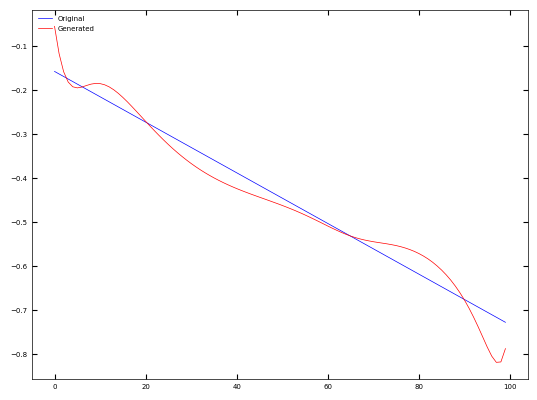

In [77]:
(encoded_two_, decoded_two_) = transform_nn(next(iter(dataloader)), encoder_two, decoder_two)
rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_two_[rand].squeeze(), "r", label="Generated")
plt.legend()